In [1]:
import datetime

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline
sns.set()

In [2]:
from covid_tracking_data.collector import *
from covid_analysis.utility import *
from covid_analysis.models import *

In [3]:
 from matplotlib.axes._axes import _log as matplotlib_axes_logger
 matplotlib_axes_logger.setLevel('ERROR')

### Fetch the latest data

If the interface is overloaded, the collector will retry every few seconds.

In [4]:
df, states_in_order = get_dataset_df()

        date state  positive  negative  pending  hospitalized  death  total  \
0 2020-03-04    NY       6.0      48.0     24.0           NaN    NaN     78   
1 2020-03-05    NY      22.0      76.0     24.0           NaN    NaN    122   
2 2020-03-06    NY      33.0      92.0    236.0           NaN    NaN    361   
3 2020-03-07    NY      76.0      92.0    236.0           NaN    NaN    404   
4 2020-03-08    NY     105.0      92.0      NaN           NaN    NaN    197   

            dateChecked  order        lastUpdateEt  
0  2020-03-04T21:00:00Z      0 2020-03-22 11:00:00  
1  2020-03-05T21:00:00Z      0 2020-03-22 11:00:00  
2  2020-03-06T21:00:00Z      0 2020-03-22 11:00:00  
3  2020-03-07T21:00:00Z      0 2020-03-22 11:00:00  
4  2020-03-08T20:00:00Z      0 2020-03-22 11:00:00  
           positive      negative      pending  hospitalized       death  \
count    923.000000    797.000000   339.000000     27.000000  278.000000   
mean     123.374865    989.176913    79.436578    167.3

### Zero-day normalized log plots

/Users/drskippy/Working/2020covid19/covid_analysis/models.py:40: RuntimeWarning: divide by zero encountered in log
  log_total_by_day = np.log(non_zero_total_by_day)


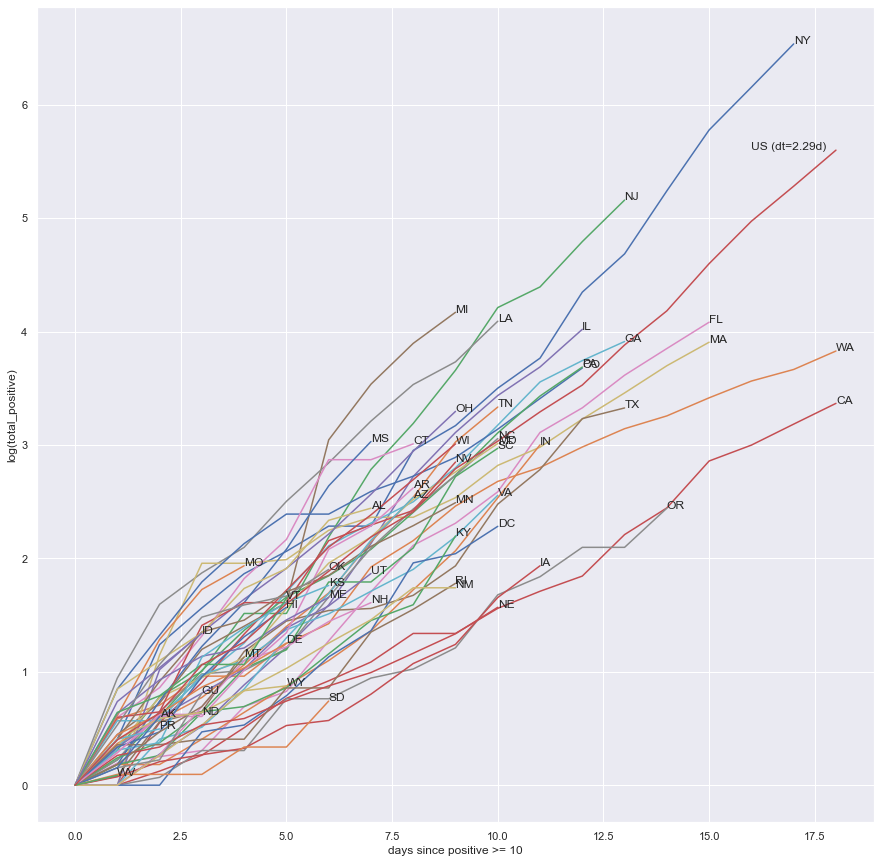

In [10]:
# start after day with min_pos or more cases
min_pos = 10

# image
plt.figure(figsize=[15,15])

# state by state
for s in states_in_order:
    try:
        dfq, dt, lud = get_state_doubling_df(df, s, zero_aligned=True, min_pos=min_pos)
        plt.plot(dfq["days_since_{}".format(min_pos)].values, dfq.log_positive.values)
        plt.annotate(s, (dfq["days_since_{}".format(min_pos)].values[-1], dfq.log_positive.values[-1]))
    except IndexError:
        pass

# All US image
try:
    dfq, dt, lud = get_state_doubling_df(df, "*", zero_aligned=True, min_pos=min_pos)
    plt.plot(dfq["days_since_{}".format(min_pos)].values, dfq.log_positive.values)
    xus = int(.9* dfq["days_since_{}".format(min_pos)].values[-1])
    plt.annotate("US (dt={:1.2f}d)".format(dt), (xus , dfq.log_positive.values[-1]))
except IndexError:
    pass

plt.xlabel("days since positive >= {}".format(min_pos))
plt.ylabel("log(total_positive)")
plt.show()

US Total Positive, doubling every 2.29 days
(2020-03-23T18:00)


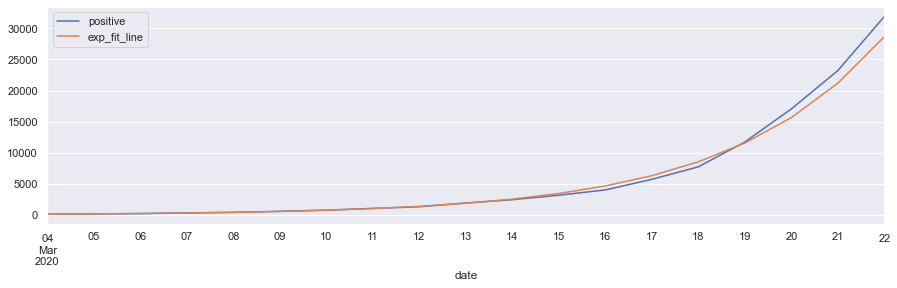

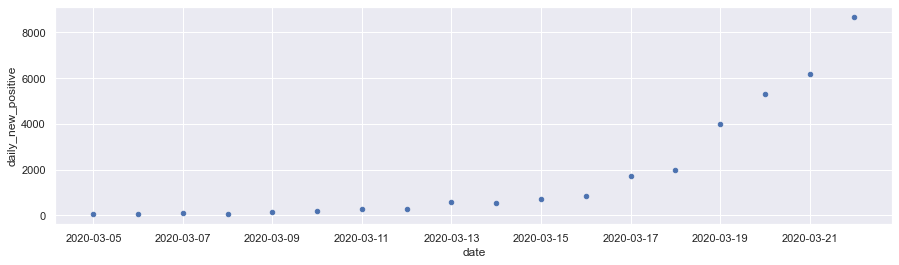

MODEL: US Total Positive, doubling every 2.29 days
(2020-03-23T18:00)


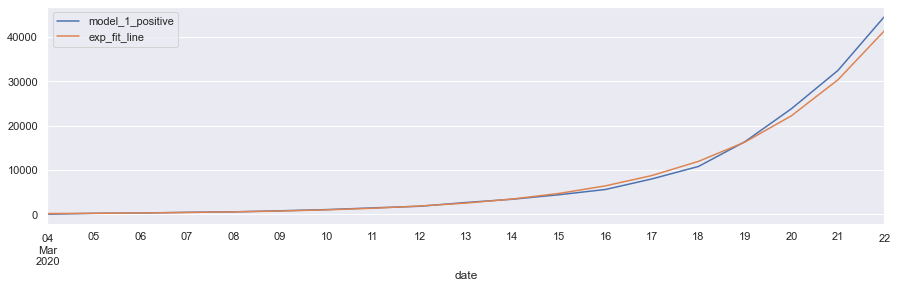

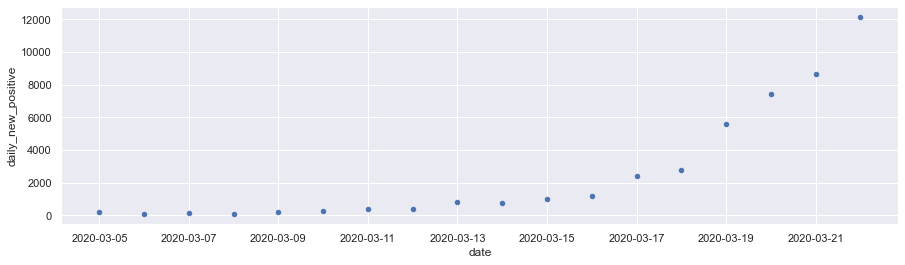

In [11]:
dfa, dt, lud = get_state_doubling_df(df, "*")
lu = str(lud)[:16]
print("US Total Positive, doubling every {:.3} days\n({})".format(dt, lu))
dfa.plot(x="date", y=["positive", "exp_fit_line"], figsize=[15,4])
dfa.plot.scatter(x="date", y="daily_new_positive", figsize=[15,4])
plt.show()
# model
dfm = model_1_actual_infections(dfa, "*")
dfma, dtm, _ = get_state_doubling_df(dfm, "*", pos_key="model_1_positive")
dfma.plot(x="date", y=["model_1_positive", "exp_fit_line"], figsize=[15,4])
lu = str(lud)[:16]
print("MODEL: US Total Positive, doubling every {:.3} days\n({})".format(dt, lu))
dfma.plot.scatter(x="date", y="daily_new_positive", figsize=[15,4])
plt.show()

In [12]:
# projections of exp growth
now, v = dfa[-1:][["date", "positive"]].values[0]
pstr = "{:3}: {:%Y-%m-%d %H h}, {:06,d}"
print(pstr.format(0, now, int(v)))
ddt = datetime.timedelta(days=dt)
for i in range(1,5):
    t = now + i*ddt
    v *= 2
    print(pstr.format(i,t,int(v)))
    

  0: 2020-03-22 00 h, 31,888
  1: 2020-03-24 06 h, 63,776
  2: 2020-03-26 13 h, 127,552
  3: 2020-03-28 20 h, 255,104
  4: 2020-03-31 03 h, 510,208


state=NY  last_update=2020-03-22T11:00
doubling every 1.83 days
(naive estimates: current_unresolved=14952 hosp=2242 icu=598)


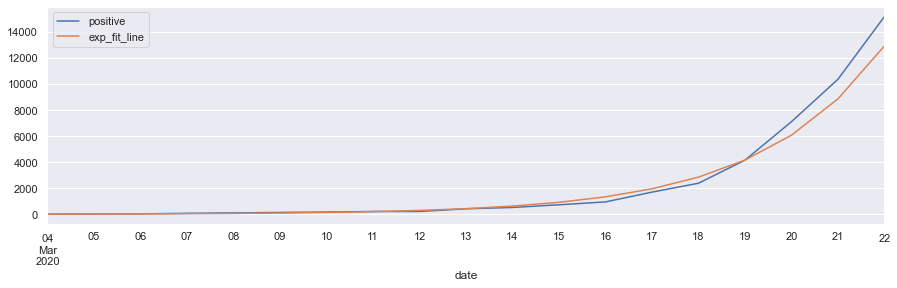

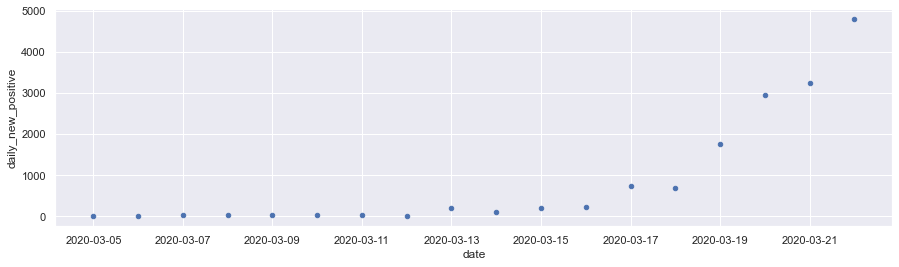

state=WA  last_update=2020-03-22T18:00
doubling every 3.3 days
(naive estimates: current_unresolved=1456 hosp=218 icu=58)


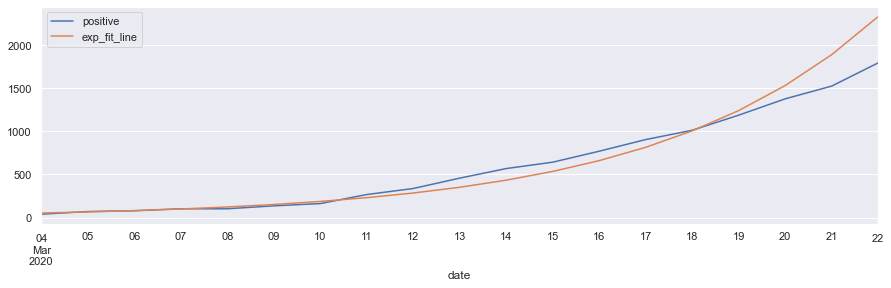

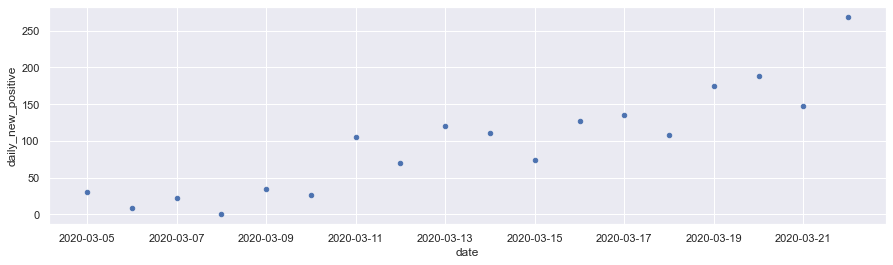

state=NJ  last_update=2020-03-22T13:30
doubling every 1.58 days
(naive estimates: current_unresolved=1884 hosp=282 icu=75)


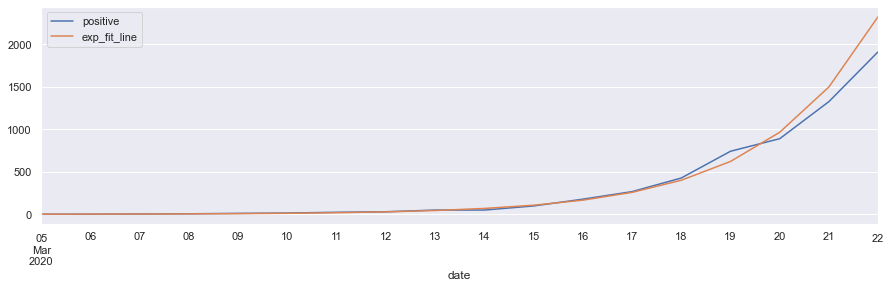

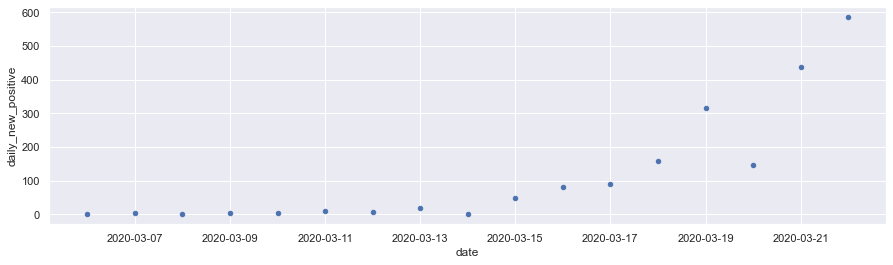

state=CA  last_update=2020-03-22T13:34
doubling every 3.55 days
(naive estimates: current_unresolved=1334 hosp=200 icu=53)


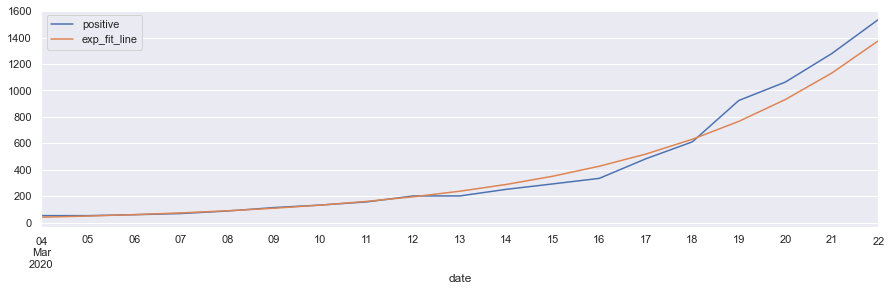

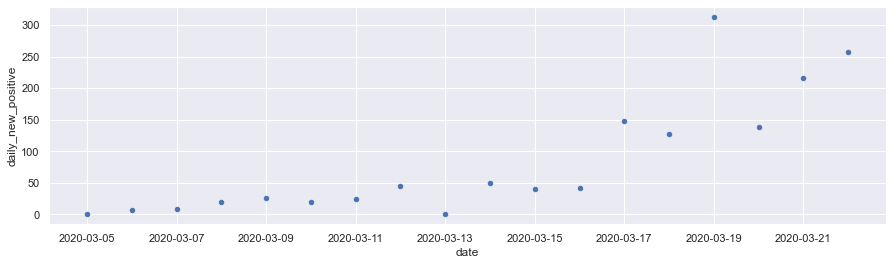

state=IL  last_update=2020-03-22T00:00
doubling every 2.09 days
(naive estimates: current_unresolved=1033 hosp=154 icu=41)


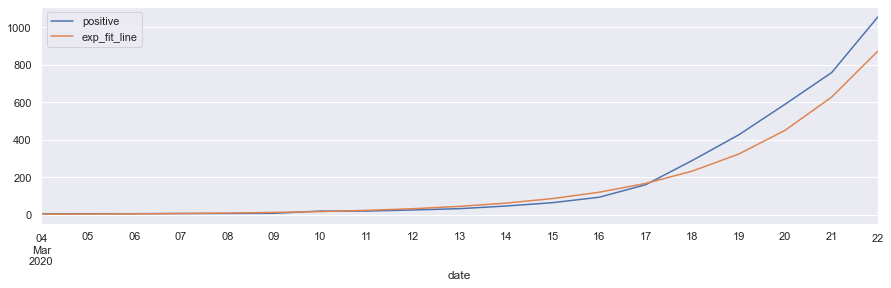

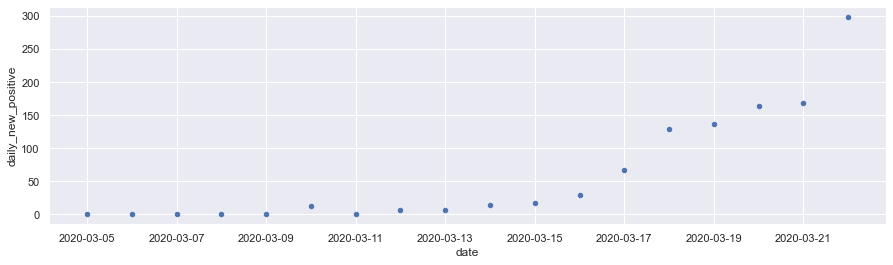

state=MI  last_update=2020-03-22T15:00
doubling every 1.22 days
(naive estimates: current_unresolved=1033 hosp=154 icu=41)


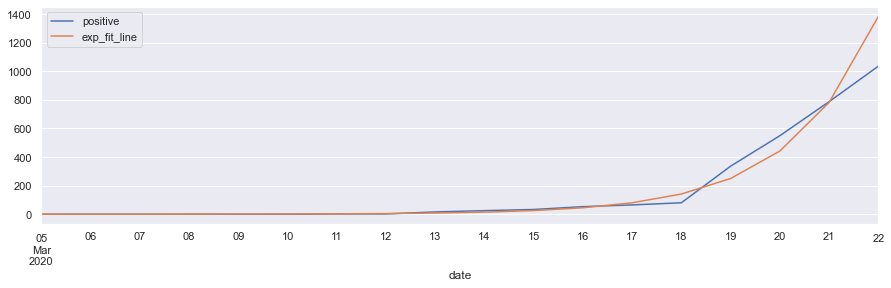

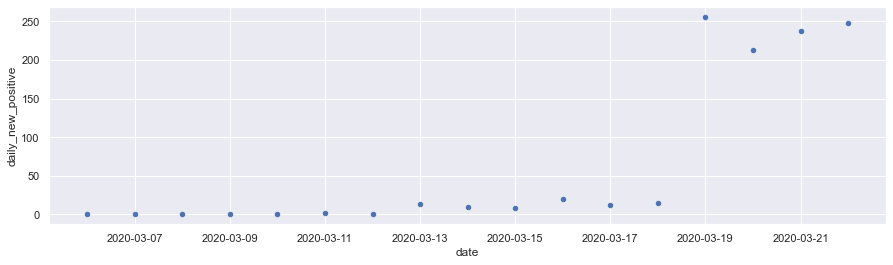

state=FL  last_update=2020-03-23T18:00
doubling every 2.32 days
(naive estimates: current_unresolved=798 hosp=119 icu=31)


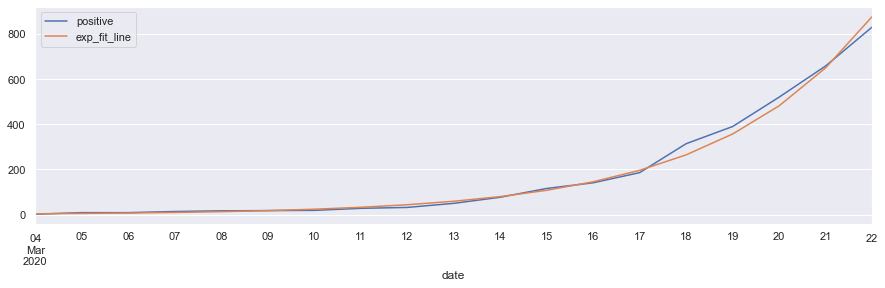

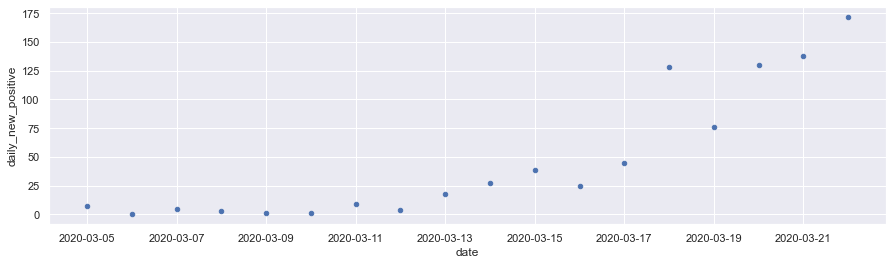

state=LA  last_update=2020-03-22T10:00
doubling every 1.36 days
(naive estimates: current_unresolved=823 hosp=123 icu=32)


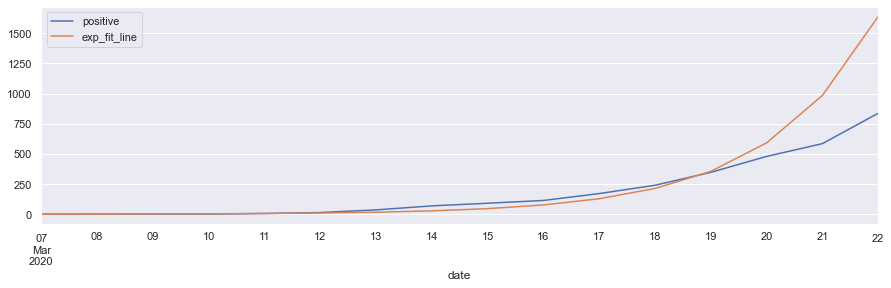

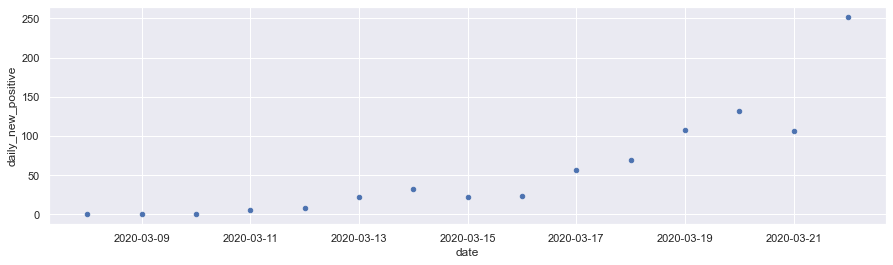

state=MA  last_update=2020-03-22T16:00
doubling every 2.35 days
(naive estimates: current_unresolved=551 hosp=82 icu=22)


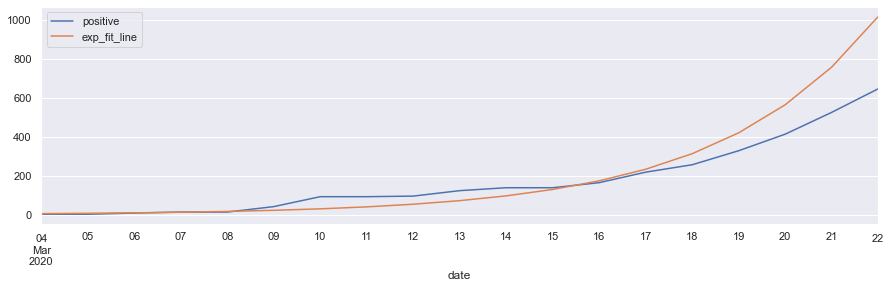

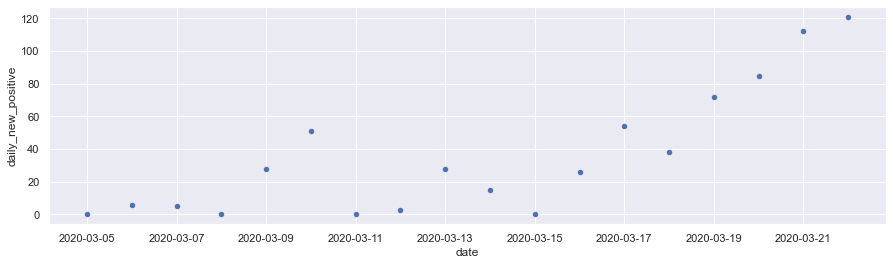

state=GA  last_update=2020-03-22T19:00
doubling every 2.05 days
(naive estimates: current_unresolved=569 hosp=85 icu=22)


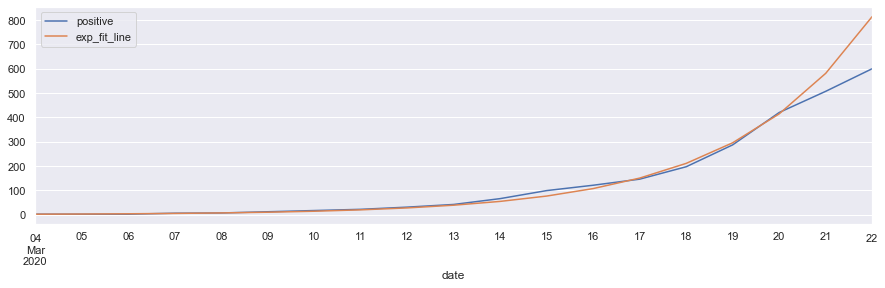

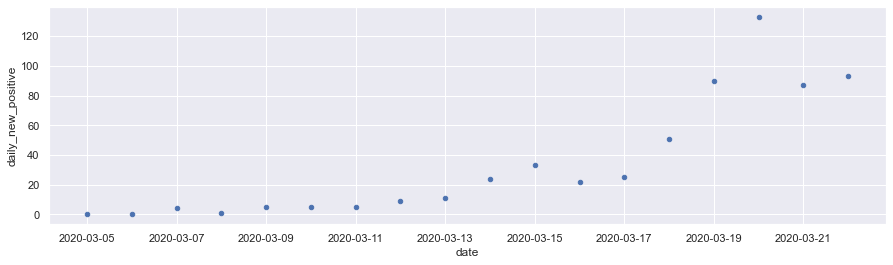

state=CO  last_update=2020-03-22T18:00
doubling every 2.24 days
(naive estimates: current_unresolved=430 hosp=64 icu=17)


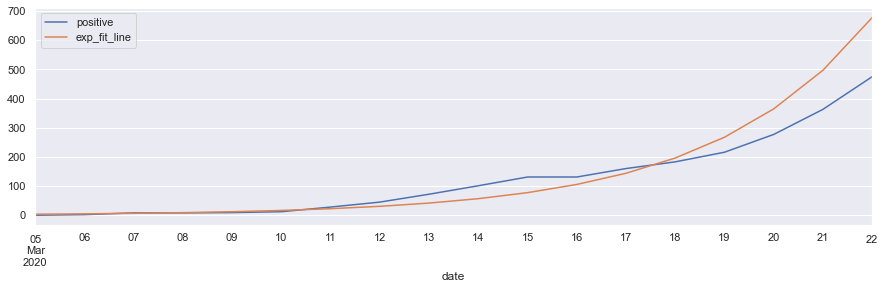

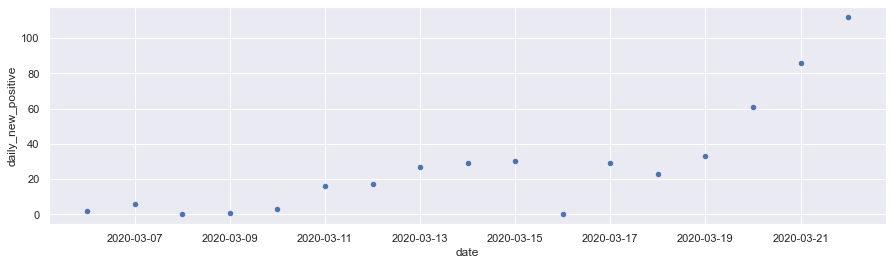

state=TN  last_update=2020-03-22T15:00
doubling every 1.82 days
(naive estimates: current_unresolved=487 hosp=73 icu=19)


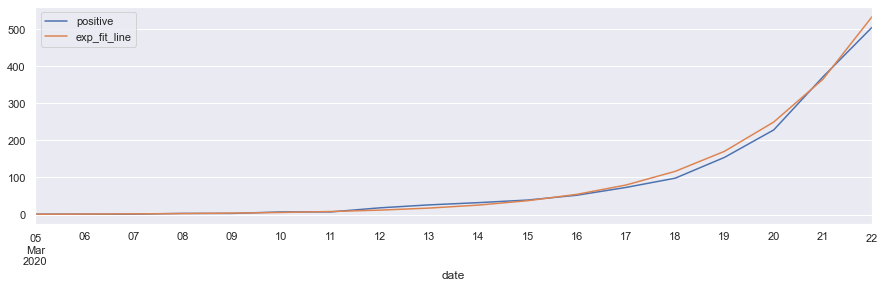

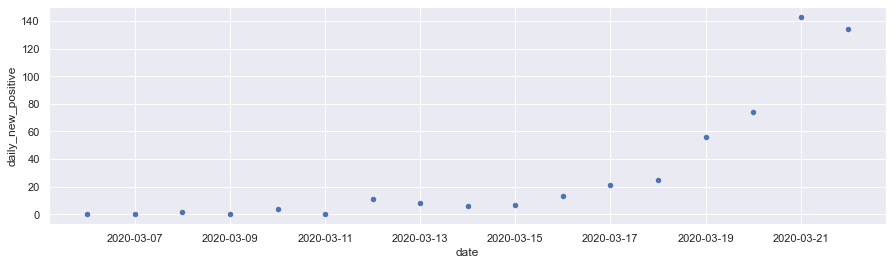

state=PA  last_update=2020-03-22T12:00
doubling every 2.02 days
(naive estimates: current_unresolved=457 hosp=68 icu=18)


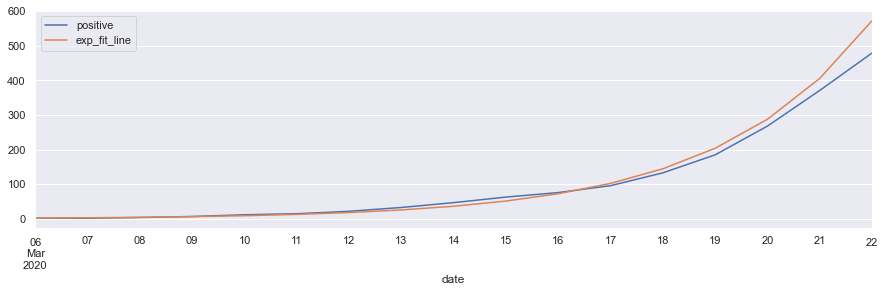

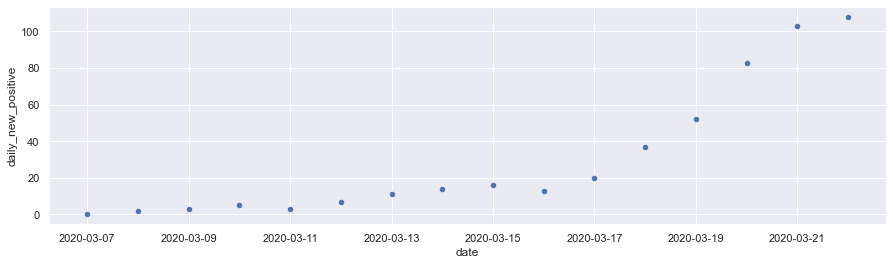

state=WI  last_update=2020-03-22T16:00
doubling every 1.78 days
(naive estimates: current_unresolved=377 hosp=56 icu=15)


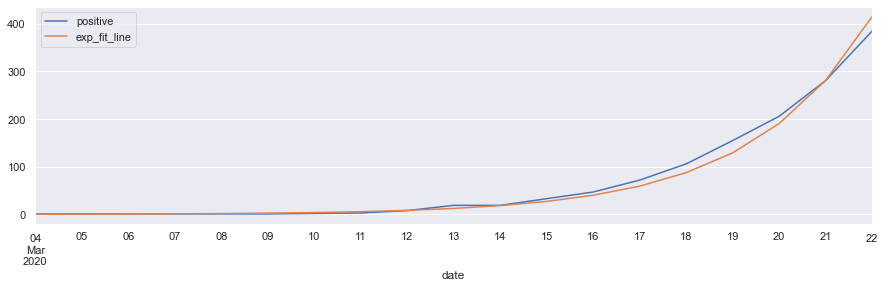

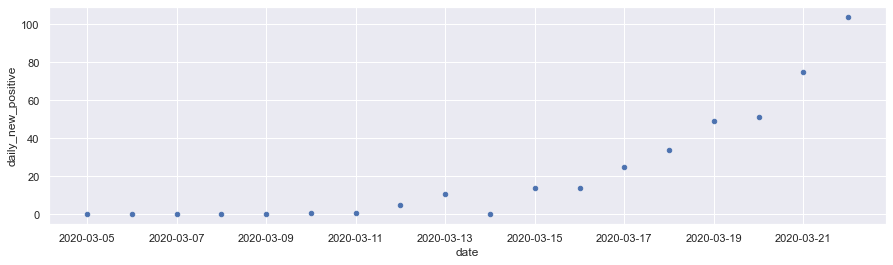

state=OH  last_update=2020-03-20T14:00
doubling every 1.74 days
(naive estimates: current_unresolved=346 hosp=51 icu=13)


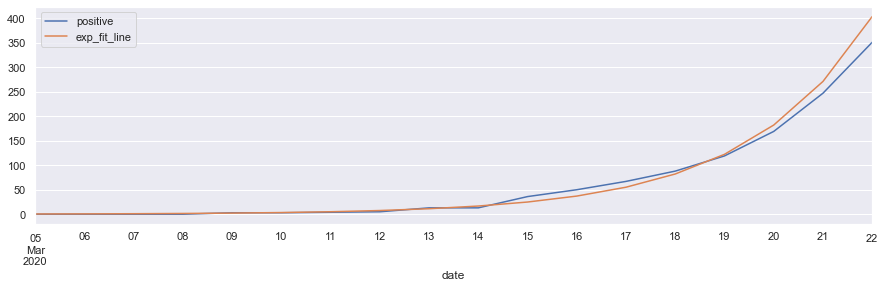

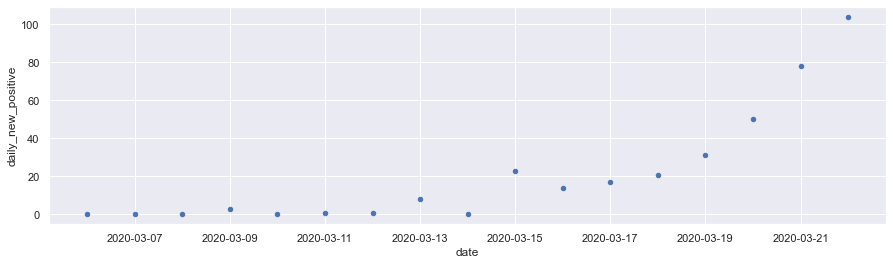

state=TX  last_update=2020-03-21T21:00
doubling every 2.37 days
(naive estimates: current_unresolved=311 hosp=46 icu=12)


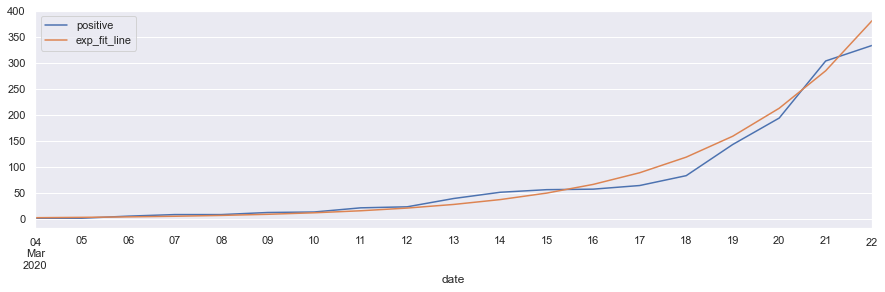

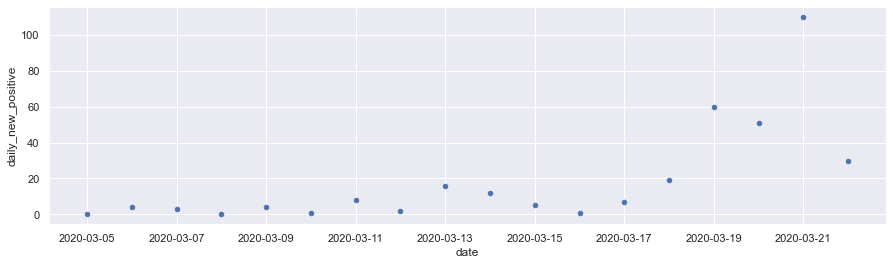

state=CT  last_update=2020-03-22T18:00
doubling every 1.64 days
(naive estimates: current_unresolved=217 hosp=32 icu=8)


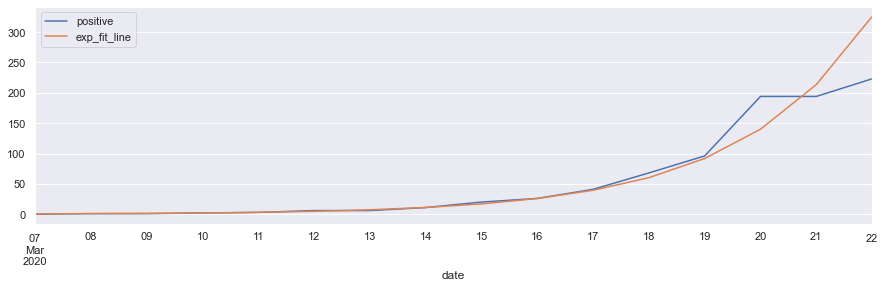

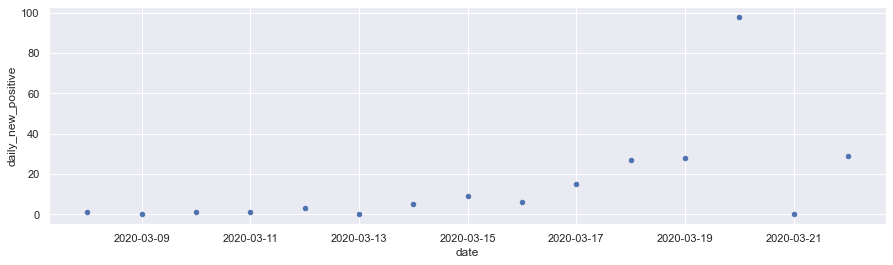

state=NC  last_update=2020-03-22T10:16
doubling every 2.17 days
(naive estimates: current_unresolved=243 hosp=36 icu=9)


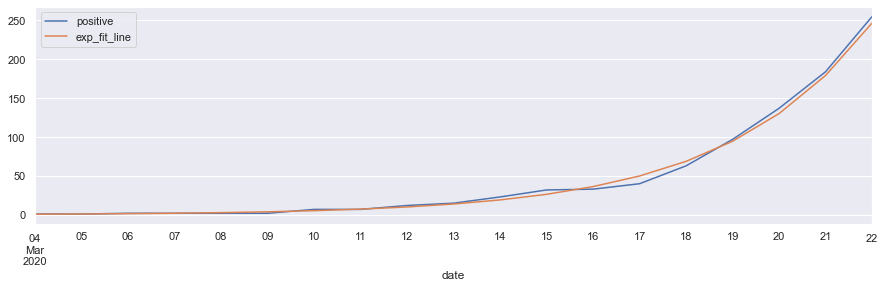

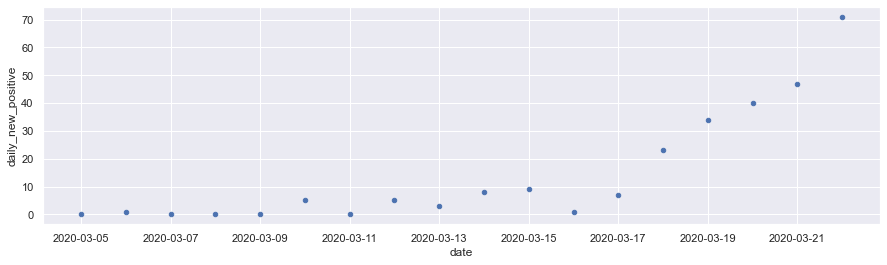

state=MD  last_update=2020-03-22T10:00
doubling every 2.32 days
(naive estimates: current_unresolved=232 hosp=34 icu=9)


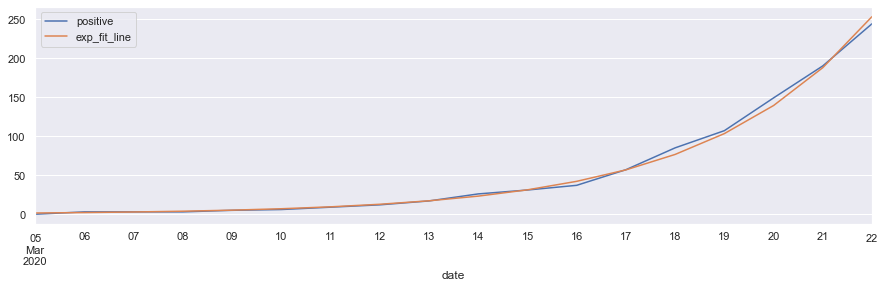

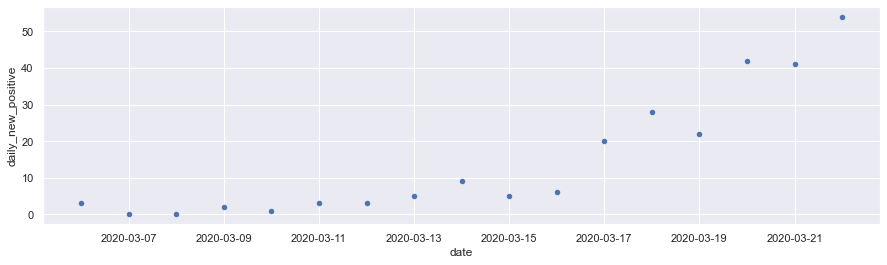

state=VA  last_update=2020-03-22T17:00
doubling every 2.26 days
(naive estimates: current_unresolved=202 hosp=30 icu=8)


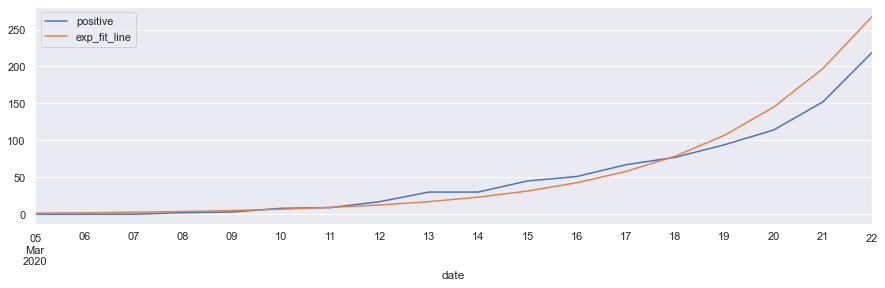

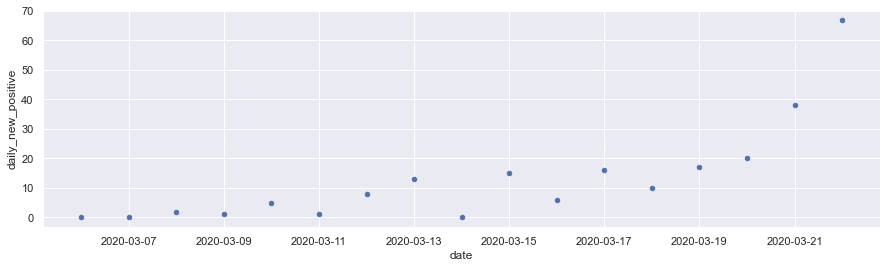

state=MS  last_update=2020-03-22T11:20
doubling every 1.44 days
(naive estimates: current_unresolved=206 hosp=30 icu=8)


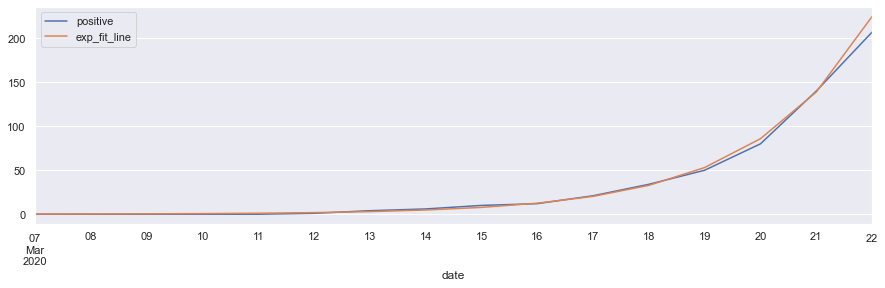

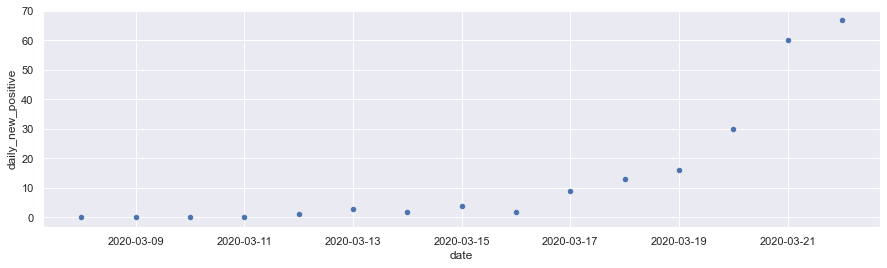

state=IN  last_update=2020-03-13T00:59
doubling every 2.22 days
(naive estimates: current_unresolved=189 hosp=28 icu=7)


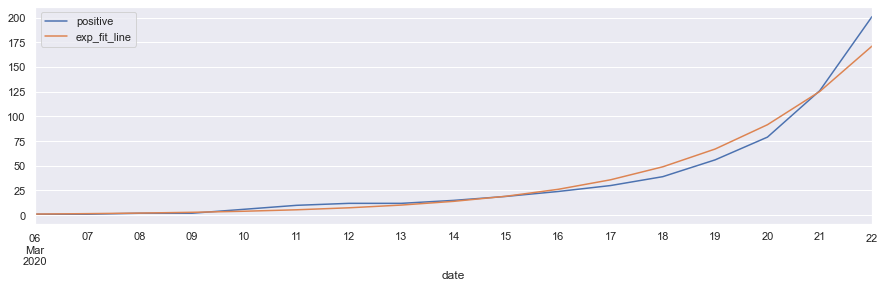

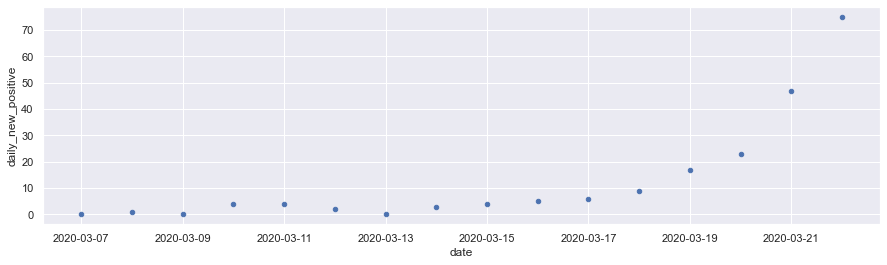

state=SC  last_update=2020-03-22T15:40
doubling every 2.44 days
(naive estimates: current_unresolved=185 hosp=27 icu=7)


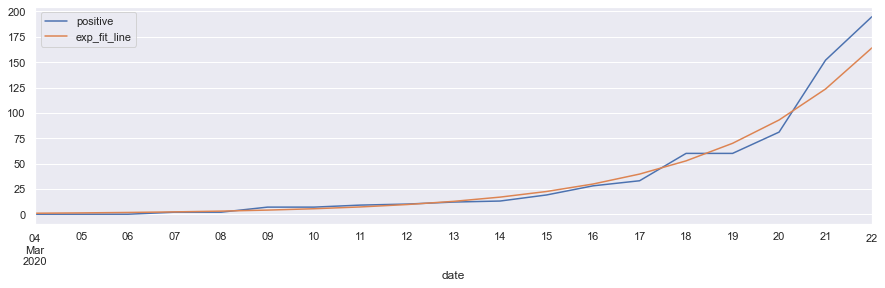

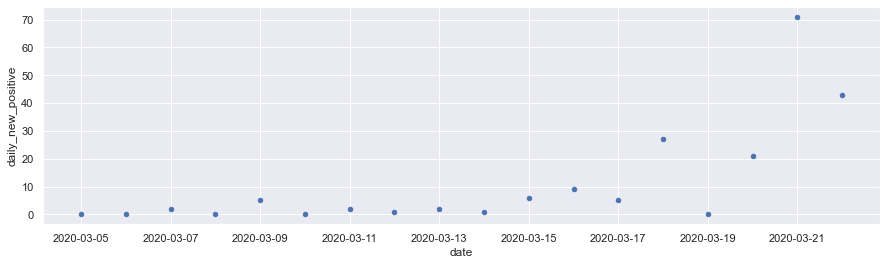

/Users/drskippy/Working/2020covid19/covid_analysis/models.py:40: RuntimeWarning: divide by zero encountered in log
  log_total_by_day = np.log(non_zero_total_by_day)


state=NV  last_update=2020-03-21T14:00
doubling every nan days
(naive estimates: current_unresolved=183 hosp=27 icu=7)


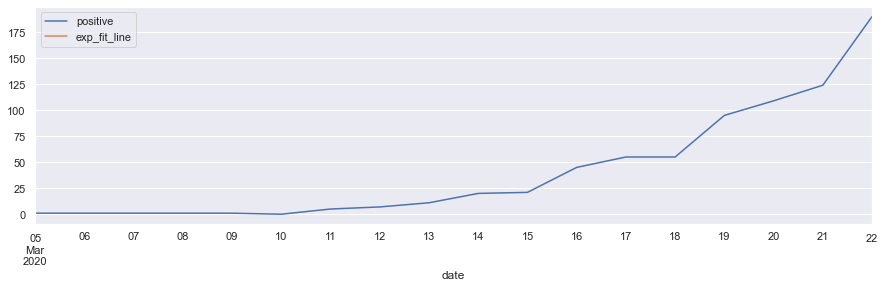

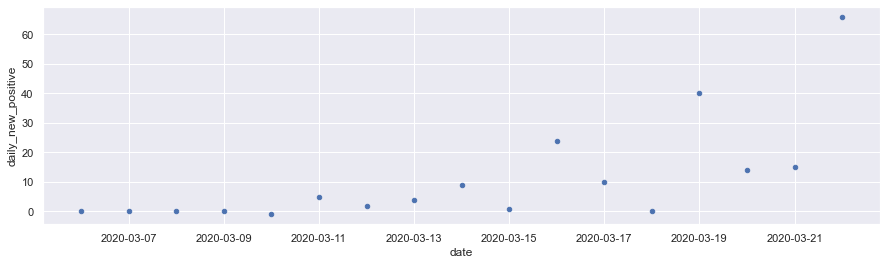

state=UT  last_update=2020-03-22T15:00
doubling every 1.74 days
(naive estimates: current_unresolved=177 hosp=26 icu=7)


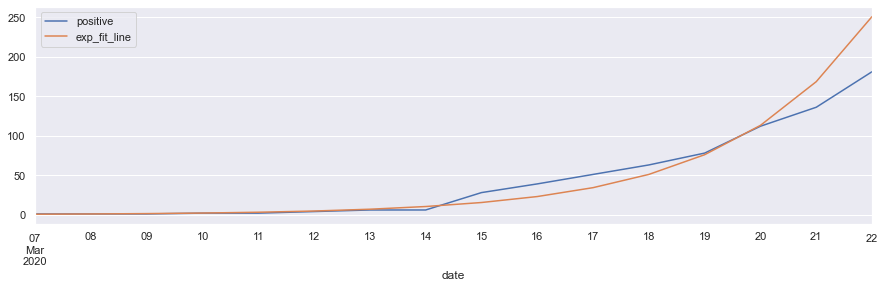

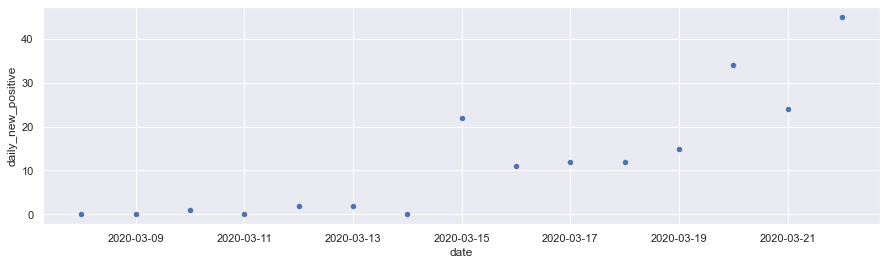

state=MN  last_update=2020-03-22T00:00
doubling every 1.89 days
(naive estimates: current_unresolved=160 hosp=24 icu=6)


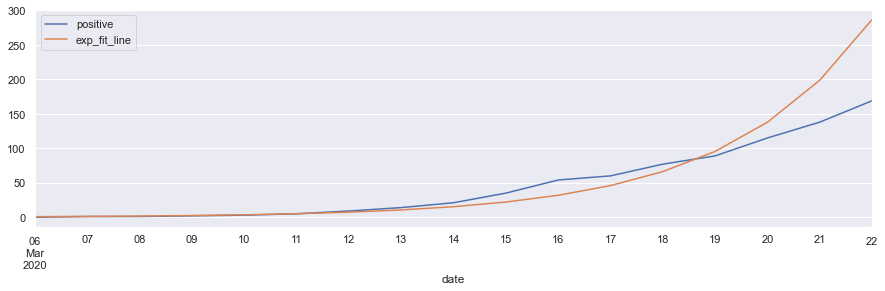

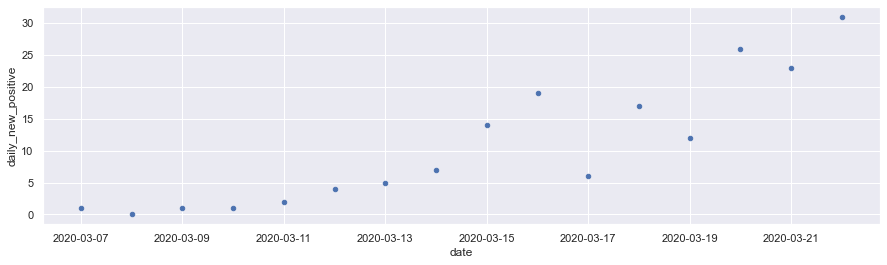

state=AR  last_update=2020-03-22T13:45
doubling every 2.14 days
(naive estimates: current_unresolved=159 hosp=23 icu=6)


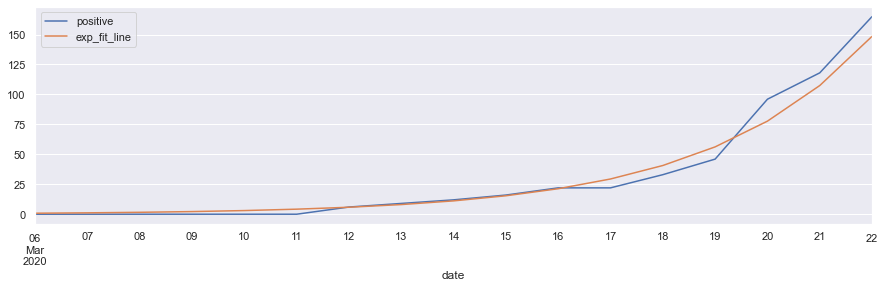

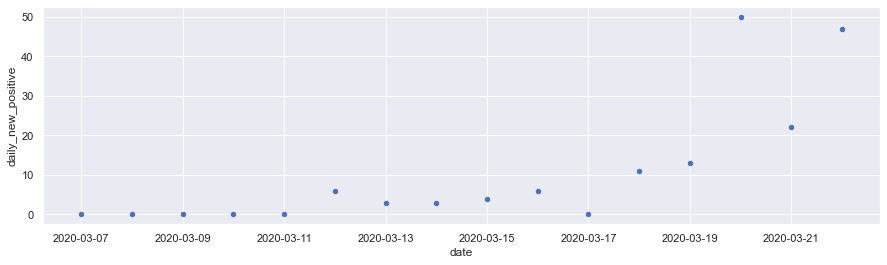

state=OR  last_update=2020-03-22T11:00
doubling every 3.2 days
(naive estimates: current_unresolved=142 hosp=21 icu=5)


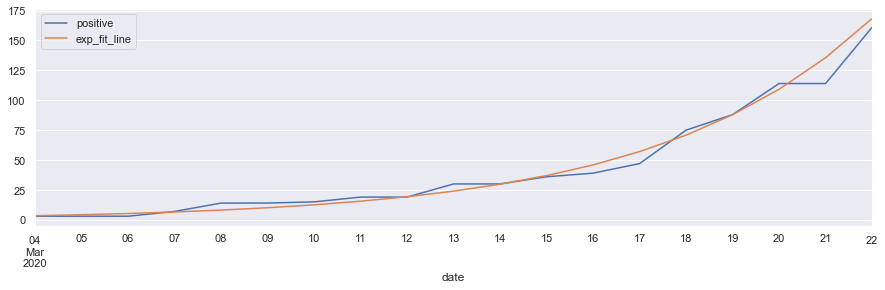

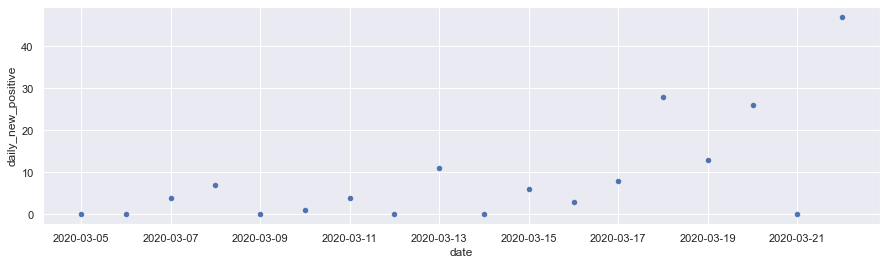

state=AL  last_update=2020-03-22T10:37
doubling every 1.47 days
(naive estimates: current_unresolved=138 hosp=20 icu=5)


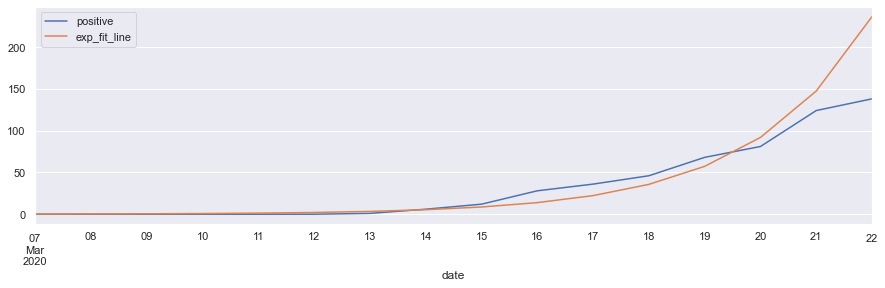

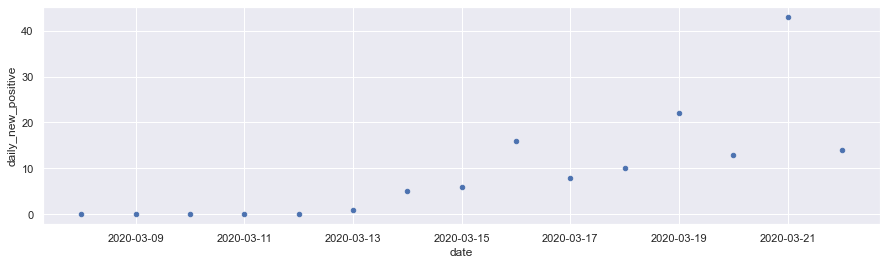

state=AZ  last_update=2020-03-22T00:00
doubling every 3.2 days
(naive estimates: current_unresolved=143 hosp=21 icu=5)


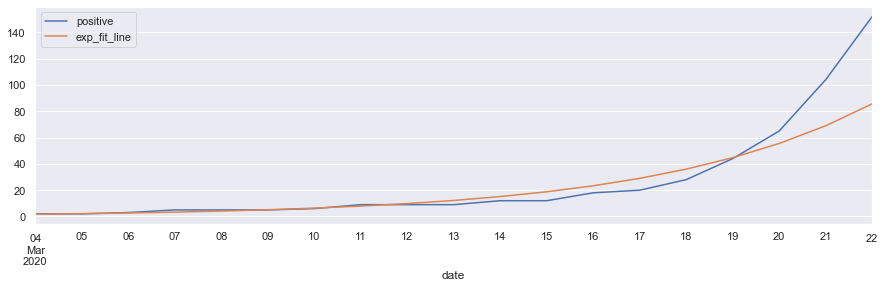

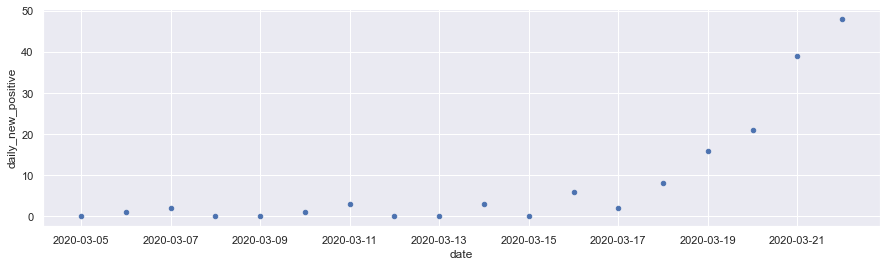

state=DC  last_update=2020-03-22T19:00
doubling every 2.26 days
(naive estimates: current_unresolved=88 hosp=13 icu=3)


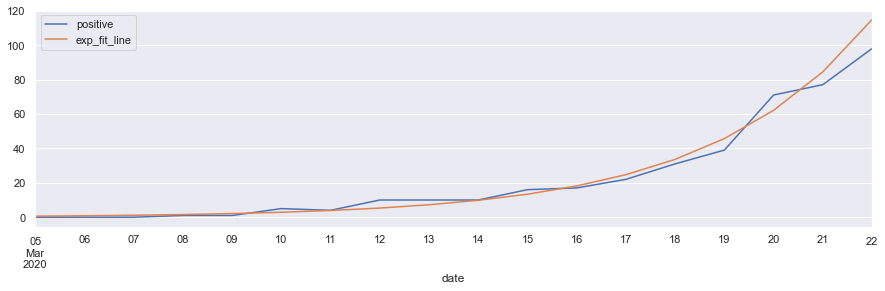

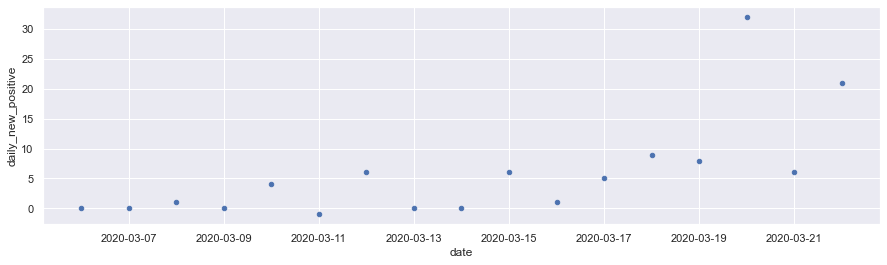

state=MO  last_update=2020-03-22T21:45
doubling every 1.94 days
(naive estimates: current_unresolved=89 hosp=13 icu=3)


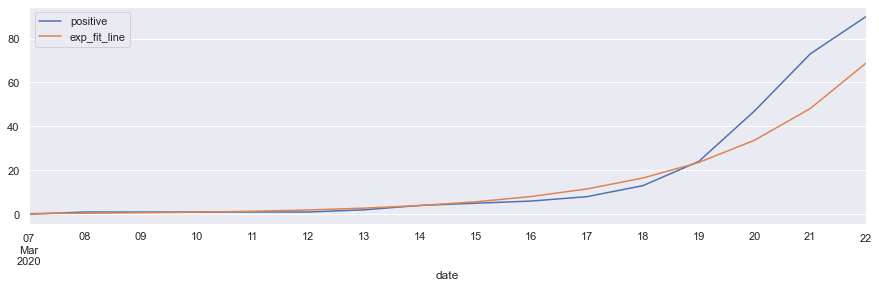

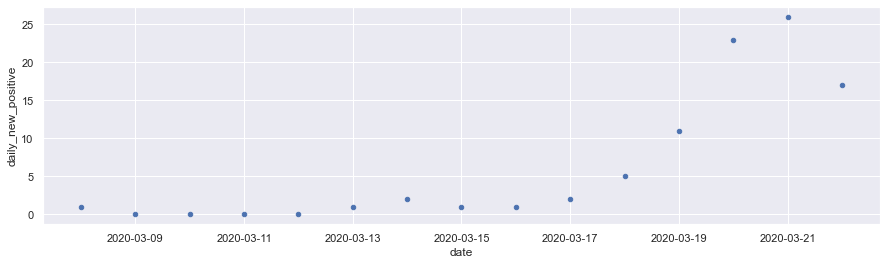

state=KY  last_update=2020-03-22T09:00
doubling every 2.63 days
(naive estimates: current_unresolved=91 hosp=13 icu=3)


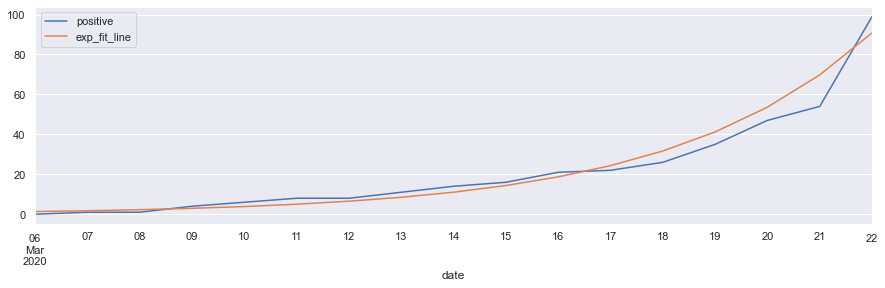

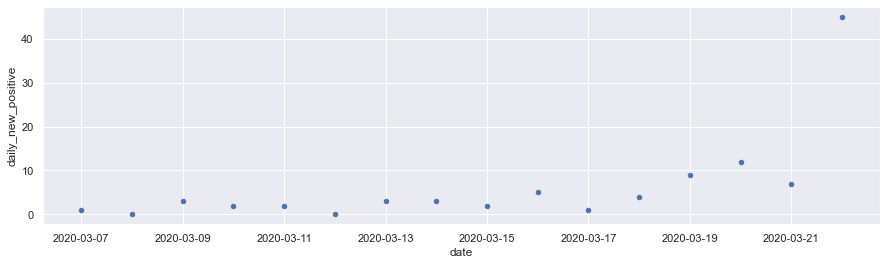

state=IA  last_update=2020-03-22T00:00
doubling every 3.5 days
(naive estimates: current_unresolved=76 hosp=11 icu=3)


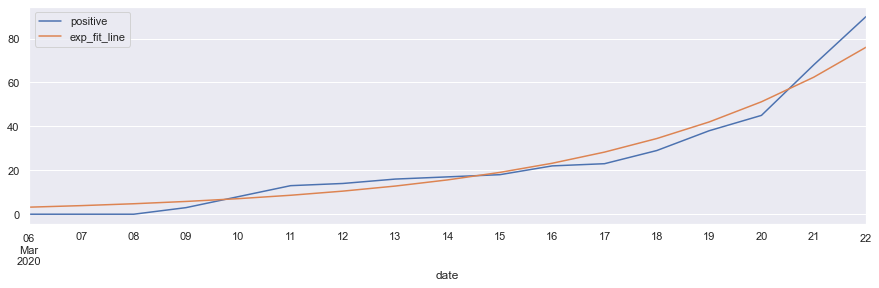

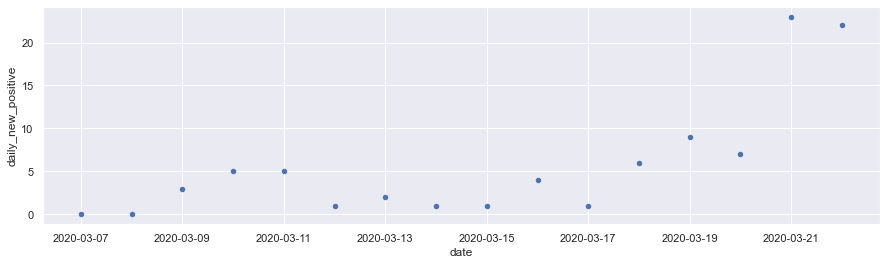

state=ME  last_update=2020-03-22T12:15
doubling every 1.5 days
(naive estimates: current_unresolved=88 hosp=13 icu=3)


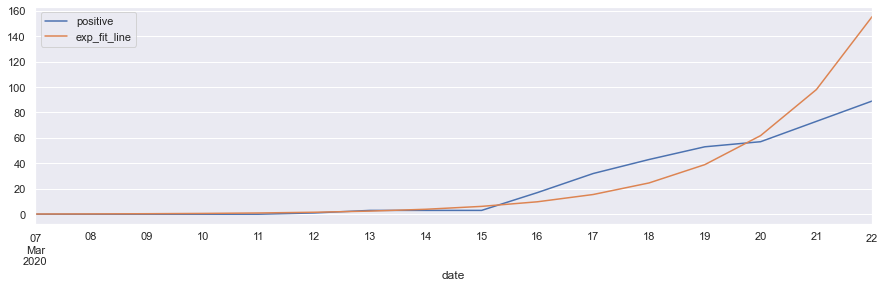

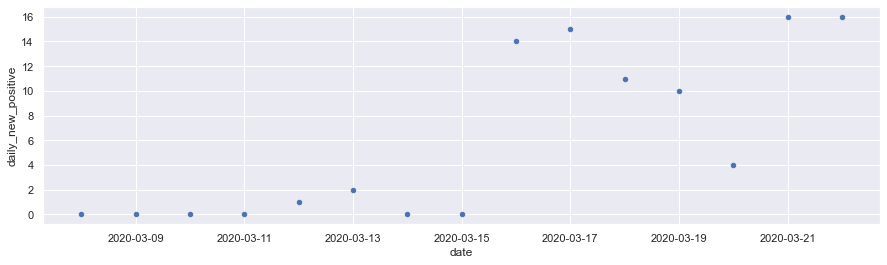

state=RI  last_update=2020-03-22T15:25
doubling every 2.76 days
(naive estimates: current_unresolved=78 hosp=11 icu=3)


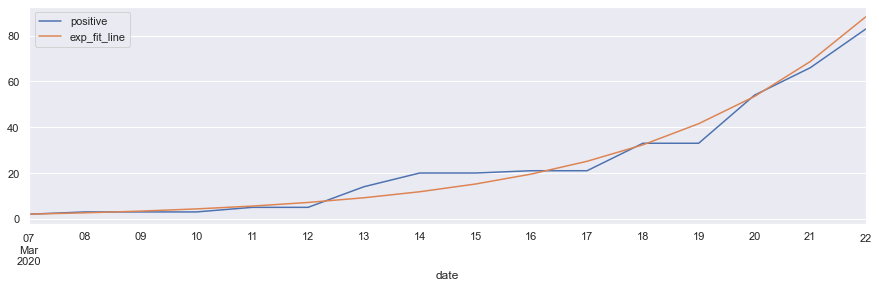

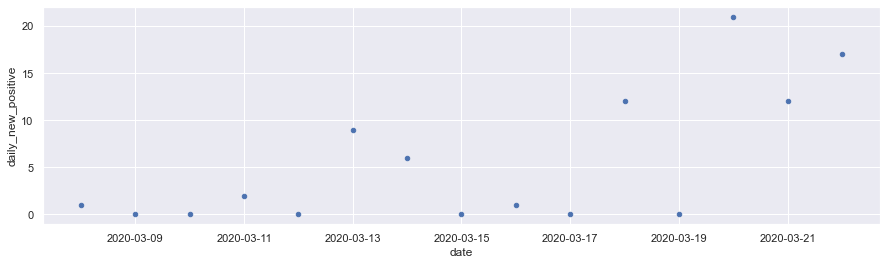

state=NH  last_update=2020-03-22T09:00
doubling every 3.33 days
(naive estimates: current_unresolved=59 hosp=8 icu=2)


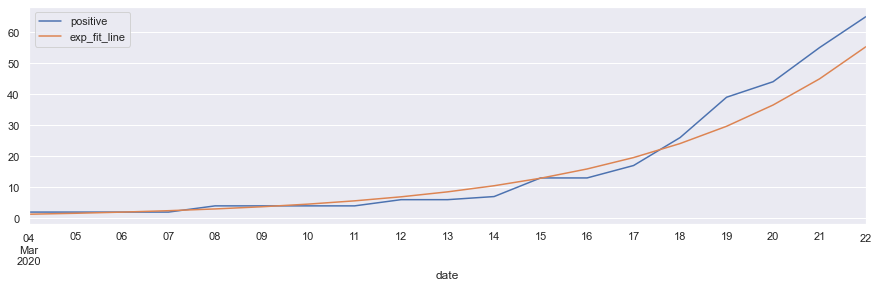

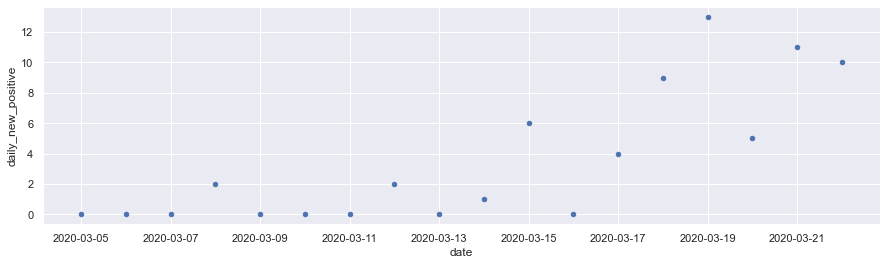

state=OK  last_update=2020-03-22T08:00
doubling every 2.17 days
(naive estimates: current_unresolved=64 hosp=9 icu=2)


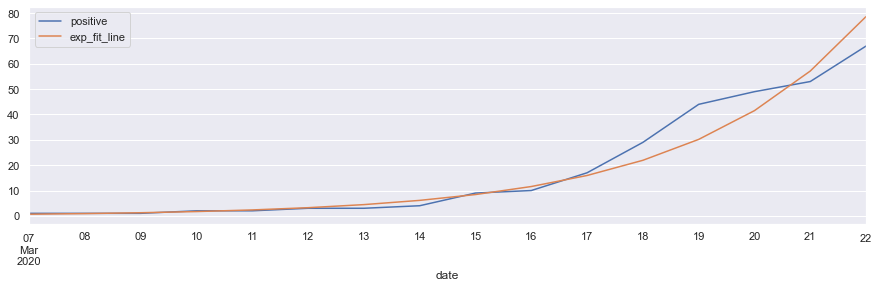

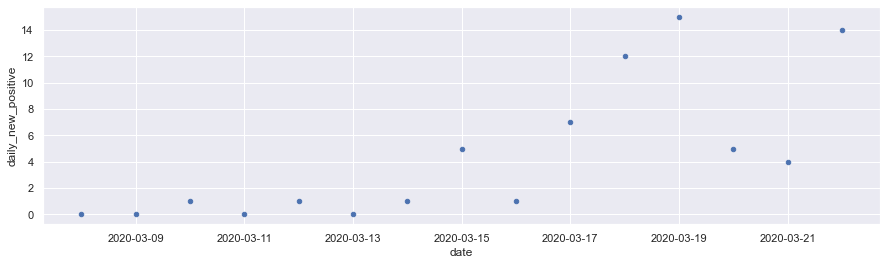

state=NM  last_update=2020-03-22T00:00
doubling every 2.7 days
(naive estimates: current_unresolved=52 hosp=7 icu=2)


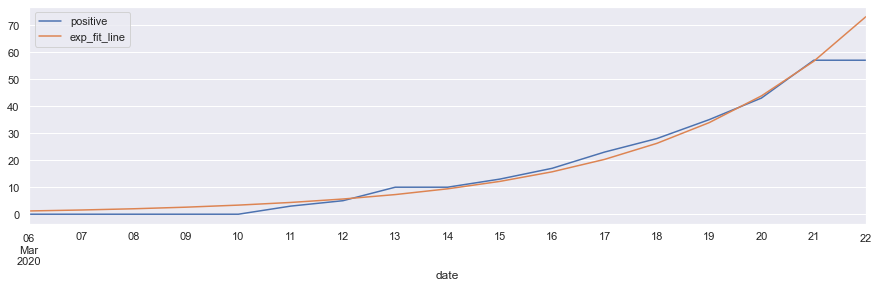

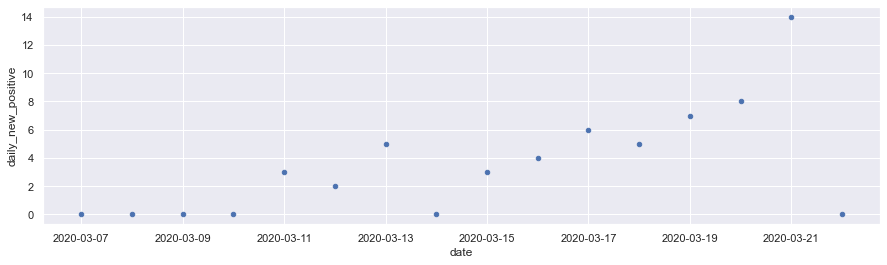

state=KS  last_update=2020-03-21T11:00
doubling every 2.09 days
(naive estimates: current_unresolved=60 hosp=9 icu=2)


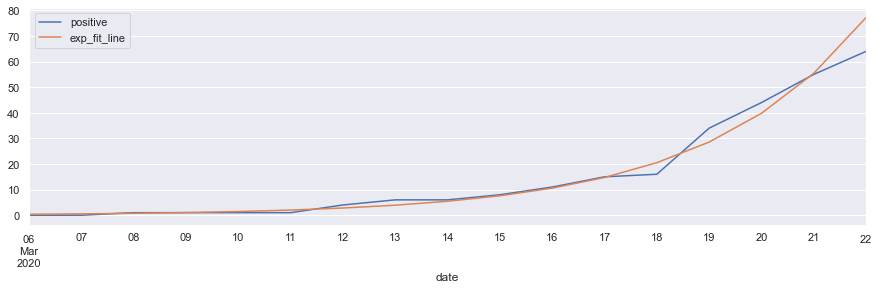

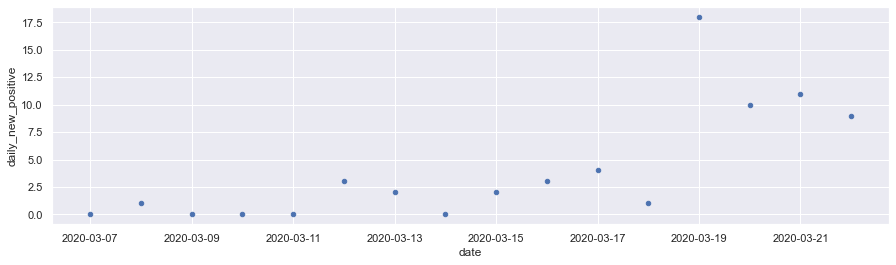

state=HI  last_update=2020-03-22T18:00
doubling every 2.66 days
(naive estimates: current_unresolved=46 hosp=6 icu=1)


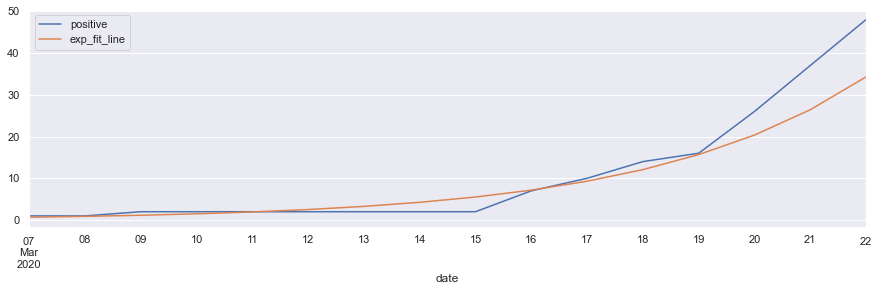

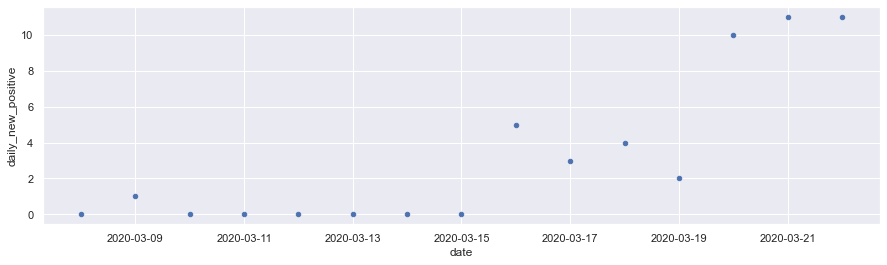

state=DE  last_update=2020-03-22T16:15
doubling every 2.09 days
(naive estimates: current_unresolved=52 hosp=7 icu=2)


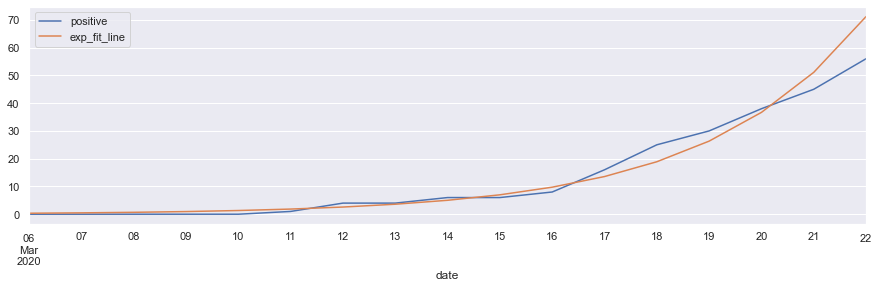

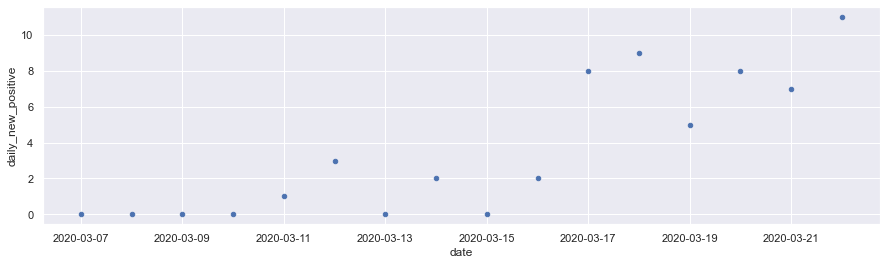

state=VT  last_update=2020-03-22T14:00
doubling every 2.21 days
(naive estimates: current_unresolved=50 hosp=7 icu=2)


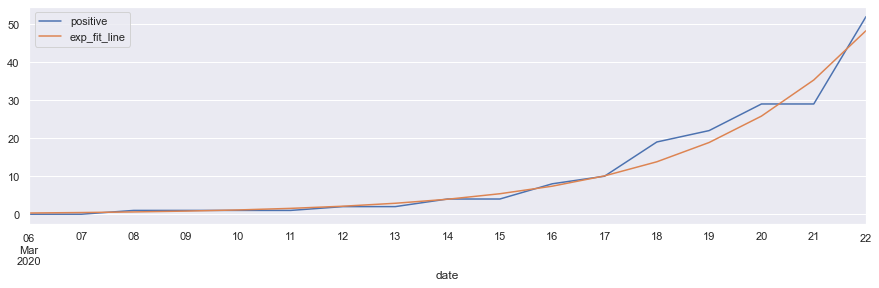

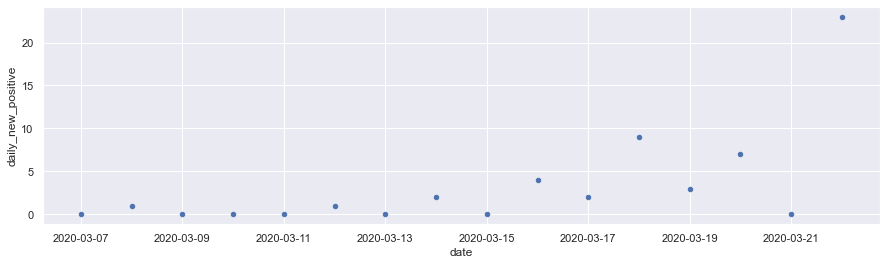

state=NE  last_update=2020-03-21T00:00
doubling every 2.82 days
(naive estimates: current_unresolved=38 hosp=5 icu=1)


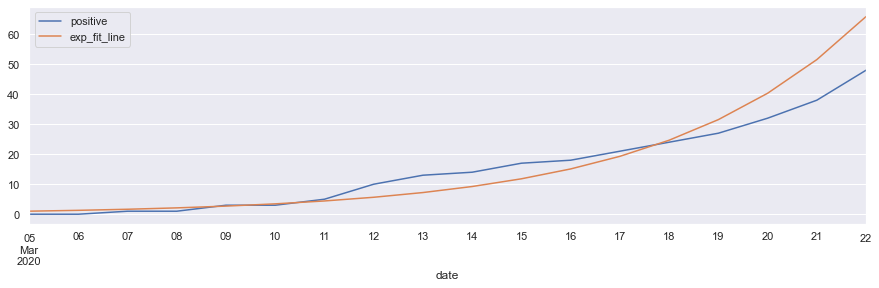

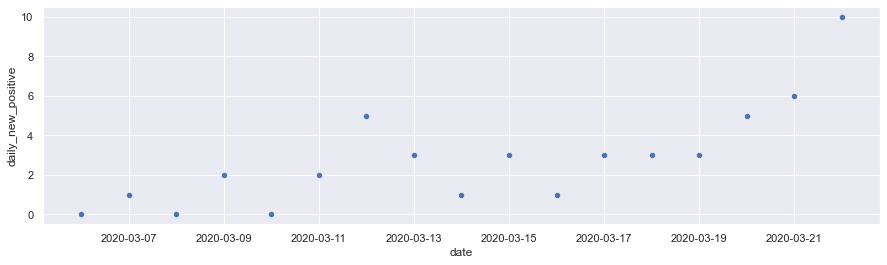

state=ID  last_update=2020-03-21T19:55
doubling every 1.97 days
(naive estimates: current_unresolved=42 hosp=6 icu=1)


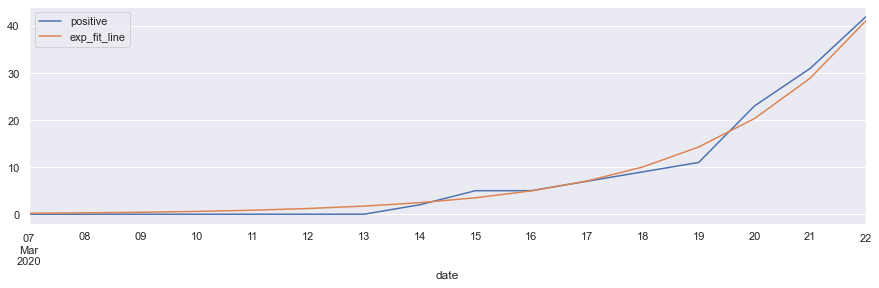

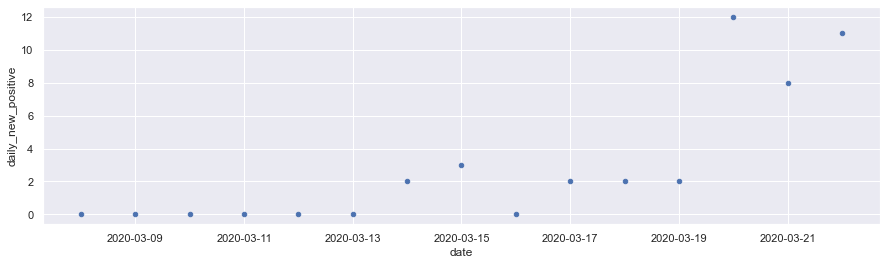

state=MT  last_update=2020-03-22T18:30
doubling every 2.24 days
(naive estimates: current_unresolved=30 hosp=4 icu=1)


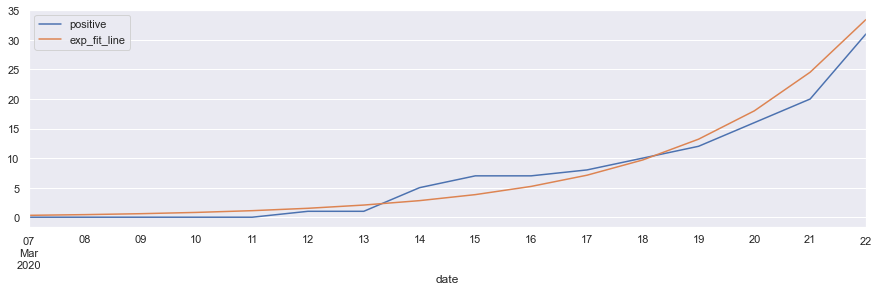

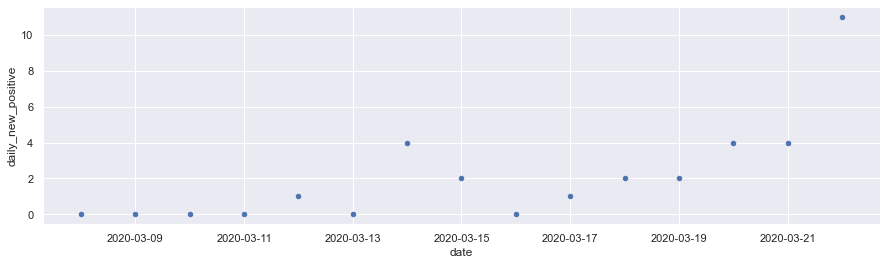

state=ND  last_update=2020-03-22T11:39
doubling every 1.65 days
(naive estimates: current_unresolved=27 hosp=4 icu=1)


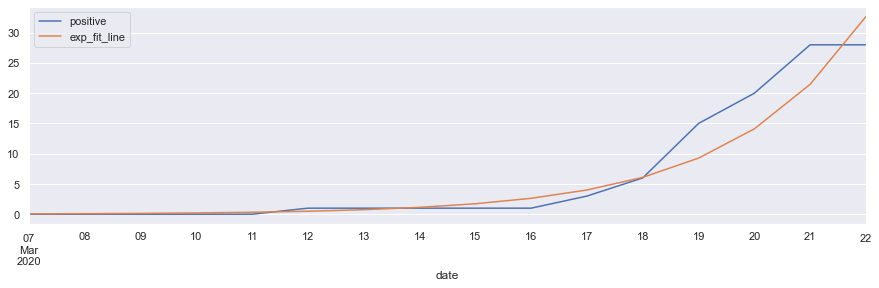

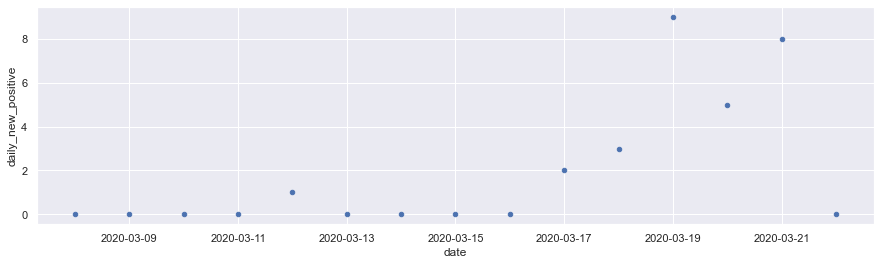

state=GU  last_update=2020-03-22T07:00
doubling every 2.08 days
(naive estimates: current_unresolved=0 hosp=0 icu=0)


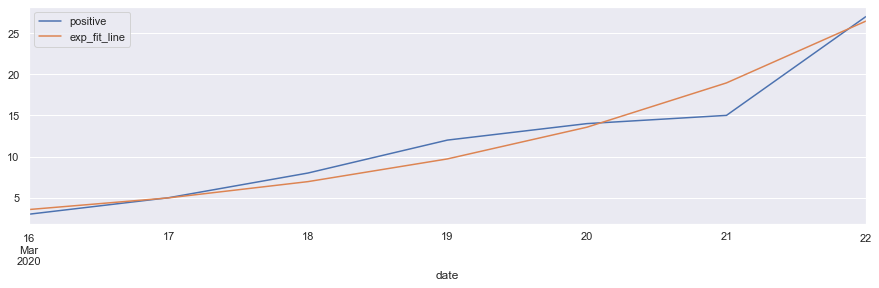

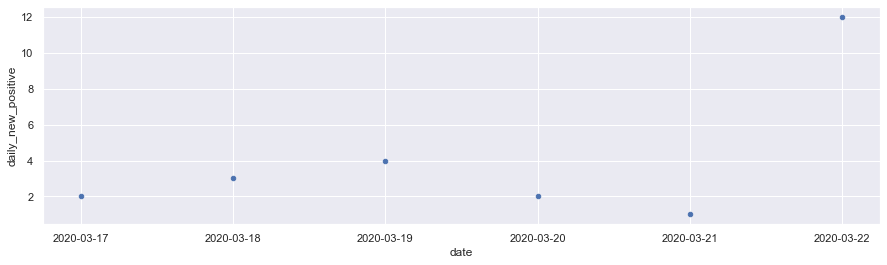

state=WY  last_update=2020-03-22T23:00
doubling every 1.89 days
(naive estimates: current_unresolved=23 hosp=3 icu=0)


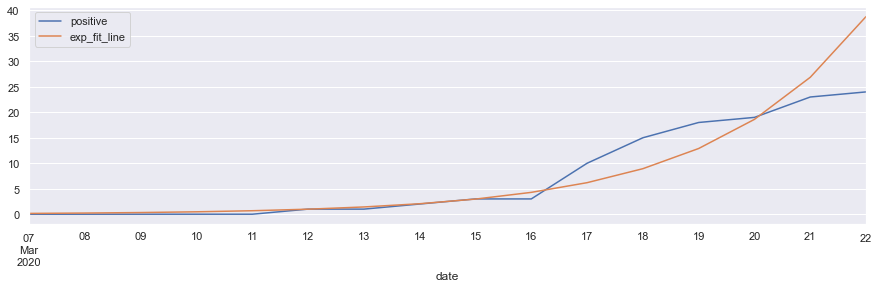

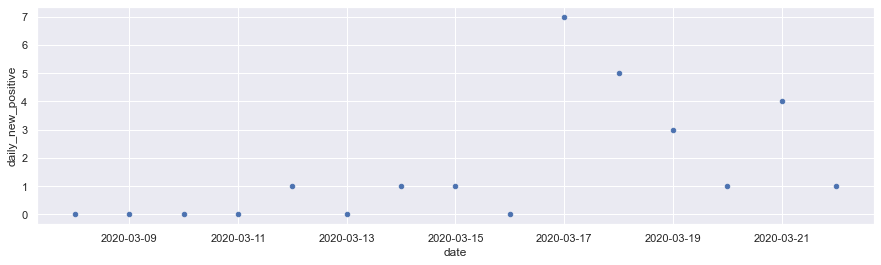

state=PR  last_update=2020-03-22T07:00
doubling every 2.29 days
(naive estimates: current_unresolved=0 hosp=0 icu=0)


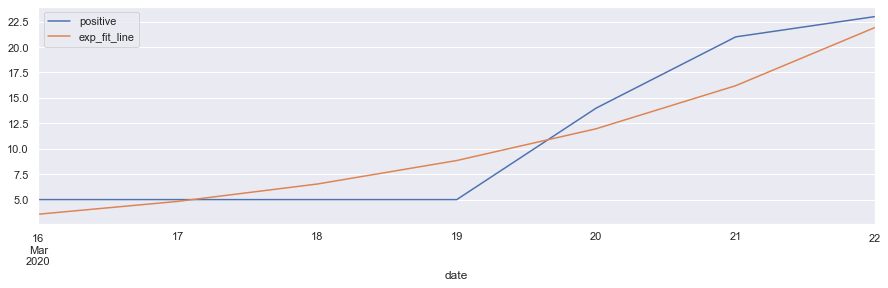

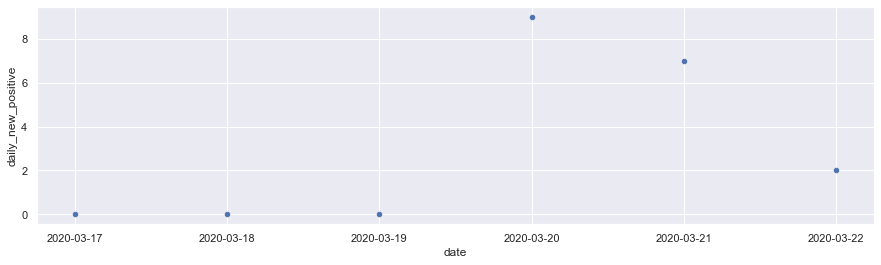

state=AK  last_update=2020-03-21T16:30
doubling every 1.77 days
(naive estimates: current_unresolved=22 hosp=3 icu=0)


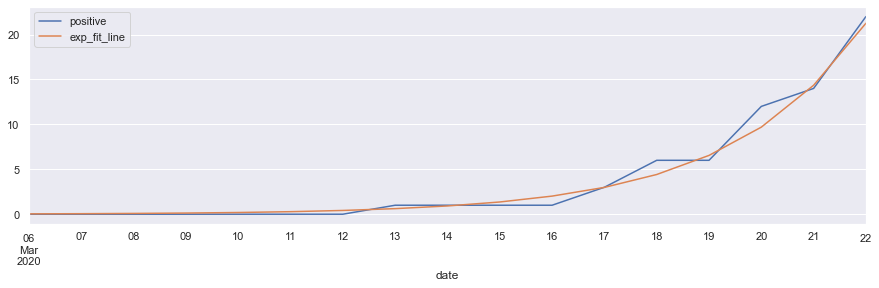

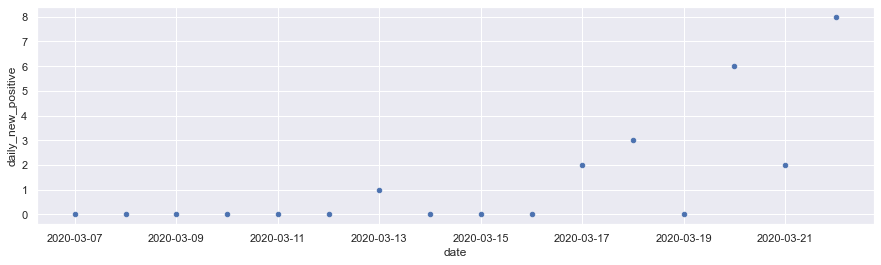

state=SD  last_update=2020-03-22T12:30
doubling every 7.74 days
(naive estimates: current_unresolved=13 hosp=1 icu=0)


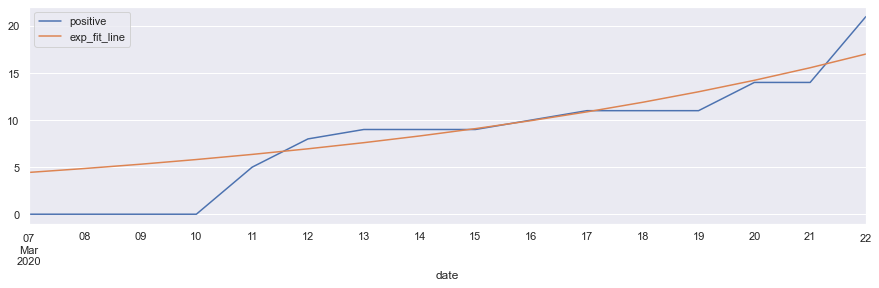

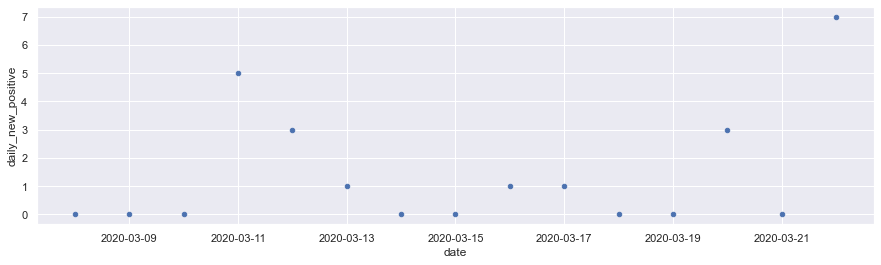

state=VI  last_update=2020-03-22T20:30
doubling every 2.43 days
(naive estimates: current_unresolved=0 hosp=0 icu=0)


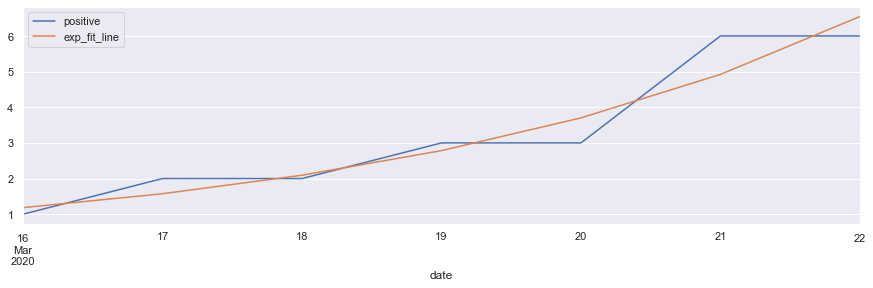

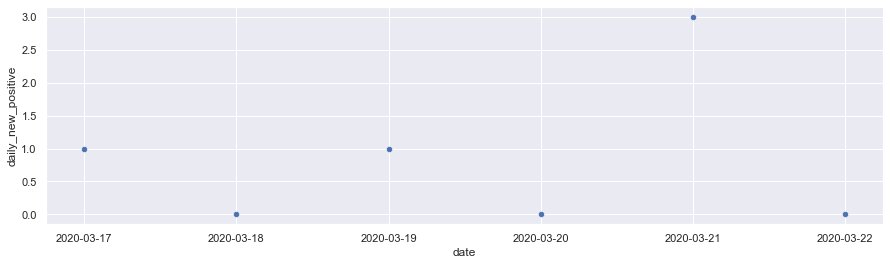

state=WV  last_update=2020-03-22T19:00
doubling every 1.04 days
(naive estimates: current_unresolved=12 hosp=1 icu=0)


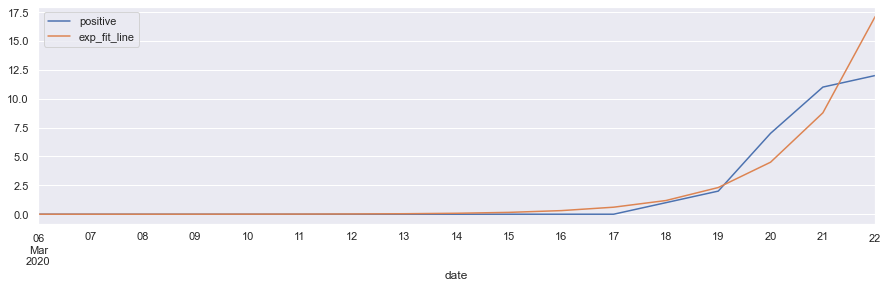

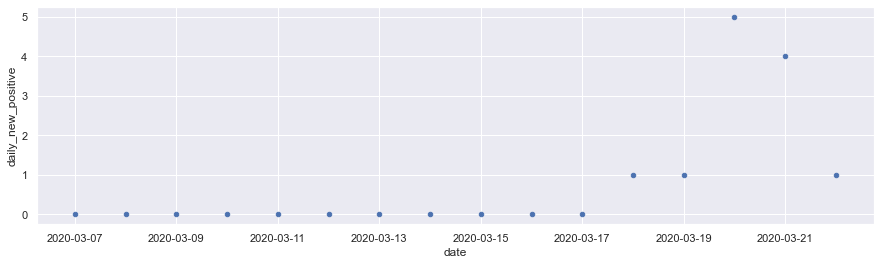

state=MP  last_update=2020-03-23T01:30
doubling every 6.93e+09 days
(naive estimates: current_unresolved=0 hosp=0 icu=0)


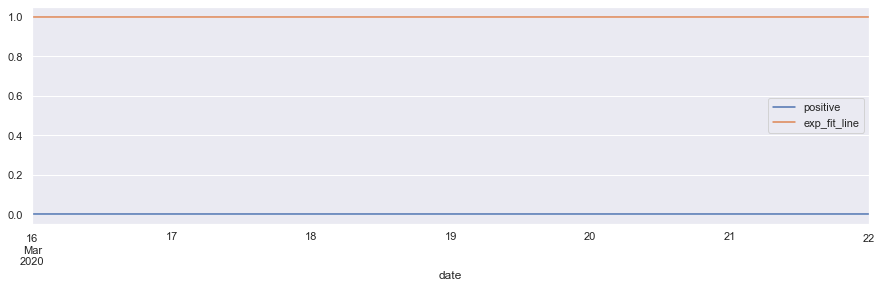

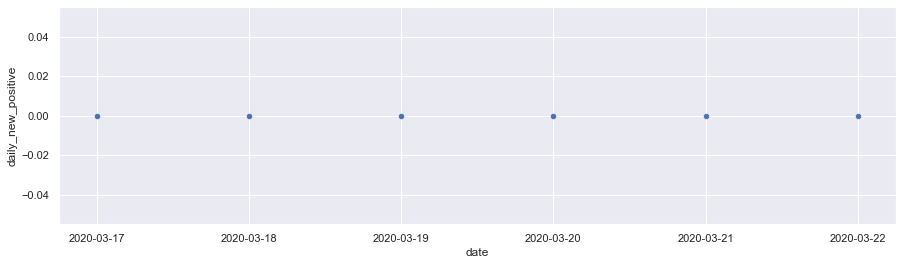

state=AS  last_update=2020-03-19T00:00
doubling every nan days
(naive estimates: current_unresolved=0 hosp=0 icu=0)


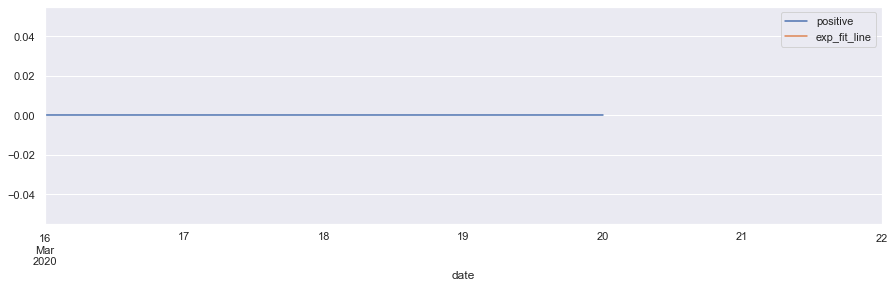

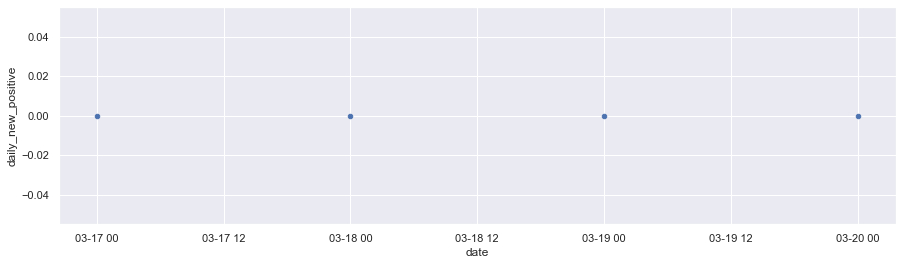

In [8]:
for s in states_in_order:
    dfq, dt, lud = get_state_doubling_df(df, s)
    cn, cnh, cni = estimate_current_cases(dfq.daily_new_positive.values)
    lu = str(lud)[:16]
    print("state={}  last_update={}\ndoubling every {:.3} days\n(naive estimates: current_unresolved={} hosp={} icu={})".format(
        s, lu, dt, cn, cnh, cni))
    dfq.plot(x="date", y=["positive", "exp_fit_line"], figsize=[15,4])
    if len(dfq) > 1:
        dfq.plot.scatter(x="date", y="daily_new_positive", figsize=[15,4])
    plt.show()

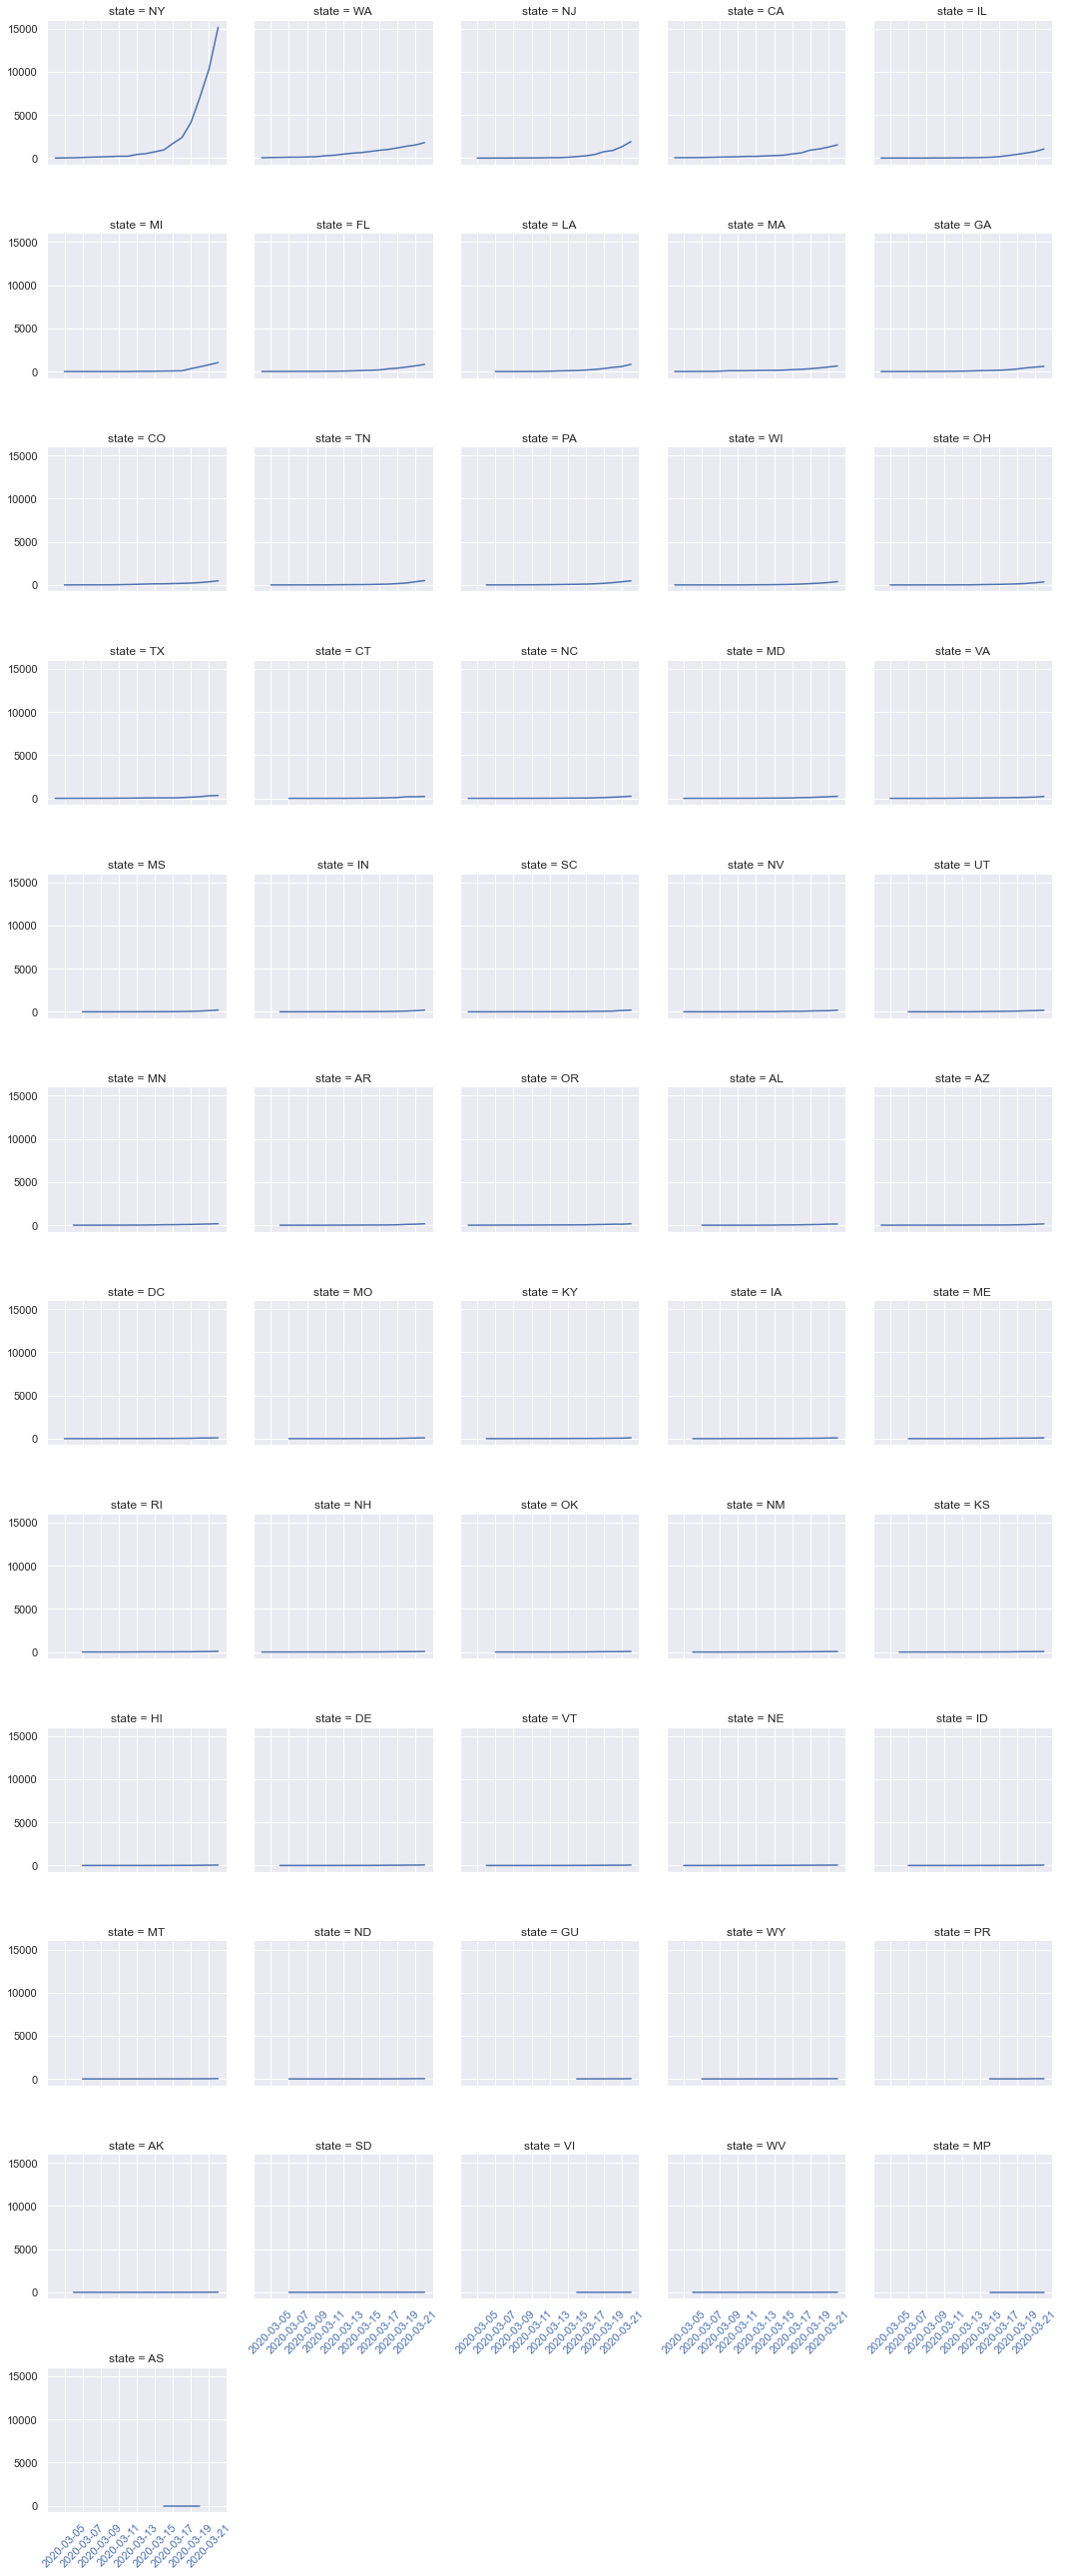

In [9]:
g = sns.FacetGrid(df, col="state", col_wrap=5, height=3, margin_titles=True)
g.map(plt.plot,"date","positive",color="b")
g.map(plt.xticks, rotation=45)